In [15]:
import json

def read_dercole2010_data(filepath='Dercole2010/wpd.json'):
    """
    Read and parse the Dercole2010 wpd.json file.
    
    Parameters:
    -----------
    filepath : str
        Path to the wpd.json file (default: 'Dercole2010/wpd.json')
    
    Returns:
    --------
    dict
        Parsed JSON data from the file
    """
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON file: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error reading file: {e}")
        return None

# Example usage:
dercole_data = read_dercole2010_data()
# if dercole_data:
#     print("Available keys:", list(dercole_data.keys()))

In [16]:
def extract_dercole_data(dercole_data):
    """
    Extract x and y values from each element in datasetColl.
    
    Parameters:
    -----------
    dercole_data : dict
        The parsed JSON data from Dercole2010
    
    Returns:
    --------
    dict
        Dictionary with dataset names as keys and {'x': [...], 'y': [...]} as values
    """
    if not dercole_data or 'datasetColl' not in dercole_data:
        print("Error: No datasetColl found in data")
        return {}
    
    extracted_data = {}
    
    for dataset in dercole_data['datasetColl']:
        # Get dataset name (use 'name' if available, otherwise use index)
        dataset_name = dataset.get('name', f"Dataset_{len(extracted_data)}")
        
        # Extract x and y values
        x_values = []
        y_values = []
        
        if 'data' in dataset:
            for point in dataset['data']:
                if 'value' in point and len(point['value']) >= 2:
                    x_values.append(point['value'][0])
                    y_values.append(point['value'][1])
        
        extracted_data[dataset_name] = {
            'x': x_values,
            'y': y_values,
            'n_points': len(x_values)
        }
        
        print(f"Dataset '{dataset_name}': {len(x_values)} points")
    
    return extracted_data

extracted = extract_dercole_data(dercole_data)

Dataset 'Na': 33 points
Dataset 'Mg': 36 points
Dataset 'Al': 43 points


In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'  # Use serif font for LaTeX labels
plt.rcParams['axes.labelsize'] = 14  # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y tick label font size

from astropy.table import Table, hstack, vstack
import pandas as pd
import os
from astropy.coordinates import SkyCoord
from astropy.io import fits

from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

%matplotlib inline
#%matplotlib notebook

In [18]:
flatex = open('latexdefs.tex', 'w')

In [19]:
def get_catalog():
    atmpars_table = Table.read("M15_M92_allframes.fits", hdu=1)
    names = [name for name in atmpars_table.columns if len(atmpars_table[name].shape) <= 1]
    atmpars = atmpars_table[names].to_pandas()
    atmpars['skycoord'] = SkyCoord(atmpars['RA'], atmpars['DEC'], unit='deg', frame='icrs')

    atmpars['teff'] = np.nan
    atmpars['tefferr'] = np.nan
    atmpars['logg'] = np.nan
    atmpars['loggerr'] = np.nan
    atmpars['vt'] = np.nan
    atmpars['vterr'] = np.nan
    for i, name in enumerate(atmpars['NAME']):
        starname = name.decode('utf-8').strip()
        if (starname == 'M92-star-5') | (starname == 'M92-star-7'):
            continue
        fname = f"ew2/{starname}_abund_teffphot.fits"
        abund = Table.read(fname, hdu=1)
        atmpars.at[i, 'teff'] = abund['TEFF']
        atmpars.at[i, 'tefferr'] = abund['TEFFERR']
        atmpars.at[i, 'logg'] = abund['LOGG']
        atmpars.at[i, 'loggerr'] = abund['LOGGERR']
        atmpars.at[i, 'vt'] = abund['VT']
        atmpars.at[i, 'vterr'] = abund['VTERR']
    return atmpars

def get_linedata(star='M92-star-7', teffphot=True, mc=False):
    fname = ("mc" if mc else "ew2")+"/"+star+"_abund" + ("mc" if mc else "byline") + ("_teffphot" if teffphot else "") + ".fits"
    if not os.path.exists(fname):
        return None
    linedata_table = Table.read(fname, hdu=1)
    names = [name for name in linedata_table.columns if len(linedata_table[name].shape) <= 1]
    linedata = linedata_table[names].to_pandas()
    
    # Decode ELEMENT column if it exists and is encoded
    if 'ELEMENT' in linedata.columns and hasattr(linedata['ELEMENT'].iloc[0], 'decode'):
        linedata['ELEMENT'] = [s.decode('utf-8').strip() for s in linedata['ELEMENT']]

    # # Discard any Na lines with LAMBDA < 5800
    # if 'ELEMENT' in linedata.columns and 'LAMBDA' in linedata.columns:
    #     # match element names that start with "Na" (case-insensitive), handle missing values safely
    #     na_mask = linedata['ELEMENT'].astype(str).str.match(r'^\s*Na', case=False, na=False)
    #     keep_mask = ~(na_mask & (linedata['LAMBDA'] < 5800))
    #     removed = len(linedata) - keep_mask.sum()
    #     linedata = linedata[keep_mask].reset_index(drop=True)

    # Combine rows with same spectral line information
    if mc:
        # Identify columns that should be grouped (repeated info) vs. varying columns
        # Typically the last few columns contain the varying measurements
        all_cols = linedata.columns.tolist()
        
        # Assume the varying columns are the last 2-5 columns that contain measurements
        # You may need to adjust this based on your specific data structure
        varying_cols = []
        grouping_cols = []
        
        for col in all_cols:
            # Check if this column has varying values for the same spectral line
            # Group by other columns and see if this one varies
            if col in ['ABUND', 'ABUNDERR', 'EW', 'EWERR', 'RW', 'RWERR', 'UPERR', 'DOWNERR', 'UPTEFF', 'UPLOGG', 'UPVT', 'UPFEH', 'UPALPHAFE', 'WEIGHT', 'UPPERLIMIT']:
                varying_cols.append(col)
            else:
                grouping_cols.append(col)
        
        if varying_cols and grouping_cols:
            # Group by the non-varying columns
            grouped = linedata.groupby(grouping_cols)
            
            # Create new combined dataframe
            combined_rows = []
            
            for name, group in grouped:
                # Create a new row with the grouping column values
                new_row = {}
                
                # Add the grouping columns (these should be identical within each group)
                for i, col in enumerate(grouping_cols):
                    if isinstance(name, tuple):
                        new_row[col] = name[i]
                    else:
                        new_row[col] = name
                
                # Convert varying columns to numpy arrays
                for col in varying_cols:
                    values = group[col].values
                    # Remove NaN values if you want, or keep them
                    new_row[col] = values
                
                combined_rows.append(new_row)
            
            # Create new DataFrame
            linedata = pd.DataFrame(combined_rows)
    
    return linedata

def get_gaia(gc='M92'):
    fname = f"gaia_{gc.lower()}.fits"
    if not os.path.exists(fname):
        return None
    gaia_table = Table.read(fname, hdu=1)
    names = [name for name in gaia_table.columns if len(gaia_table[name].shape) <= 1]
    gaia = gaia_table[names].to_pandas()
    gaia['skycoord'] = SkyCoord(gaia['ra'], gaia['dec'], unit='deg', frame='icrs')
    return gaia

In [20]:

from scipy import stats
import emcee
import corner

def gaussgauss_logL(xi, ei, mu, sigma):
    ''''
    Written: 7-11-25
    Last Updated: 7-11-25
    Equation 5.63 of AstroML book: gaussian likelihood with gaussian errors

    Inputs
    --------
    xi: abundances [X/Fe] for each stars
    ei: error on abundance
    mu: mean for dataset
    sigma: standard deviation for dataset (desired)

    Output
    --------
    log likelihood value

    '''
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)


def log_prior(theta):
    """
    Log prior probability for mu and sigma
    
    Inputs
    --------
    theta: array containing [mu, sigma]
    
    Returns
    --------
    log prior probability
    """
    mu, sigma = theta
    
    # Flat priors with reasonable bounds
    if -5.0 < mu < 5.0 and 0.0 < sigma < 2.0:
        return 0.0
    return -np.inf


def log_probability(theta, abundances, errors):
    """
    Log posterior probability (prior + likelihood)
    
    Inputs
    --------
    theta: array containing [mu, sigma]
    abundances: array of abundances [X/Fe] for all stars
    errors: associated [X/Fe] errors for all stars
    
    Returns
    --------
    log posterior probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    mu, sigma = theta
    ll = gaussgauss_logL(abundances, errors, mu, sigma)
    
    return ll #lp + ll


def get_likelihood(abundances, errors, nwalkers=32, nsteps=10000, burn_in=2000, plot_corner=False):
    """
    Compute the most likely values of mu and sigma using MCMC and return confidence intervals.
    
    Written: 7-11-25
    Last Updated: 10-9-25 (rewritten to use MCMC)

    Inputs
    --------
    abundances: array of abundances [X/Fe] for all stars of desired dataset
    errors: associated [X/Fe] errors for all stars of desired dataset
    nwalkers: number of MCMC walkers (default: 32)
    nsteps: number of MCMC steps (default: 5000)
    burn_in: number of burn-in steps to discard (default: 1000)
    plot_corner: whether to show corner plot of posterior (default: False)

    Returns
    --------
    results: dictionary containing:
        - mu: most likely mean abundance [best, lower_1sigma, upper_1sigma]
        - sigma: most likely intrinsic dispersion [best, lower_1sigma, upper_1sigma]
        - samples: MCMC samples after burn-in
        - sampler: emcee sampler object
    """
    
    # Clean the data
    mask = ~np.isnan(abundances) & ~np.isnan(errors)
    abundances = abundances[mask]
    errors = errors[mask]
    
    # print(f"Using {len(abundances)} stars for MCMC analysis")
    
    # Initial guess using weighted statistics
    weights = 1 / (errors ** 2)
    mu_init = np.sum(abundances * weights) / np.sum(weights)
    N = len(abundances)
    sigma_init = np.sqrt(np.sum(weights * (abundances - mu_init) ** 2) / (((N - 1) / N) * np.sum(weights)))
    
    # print(f"Initial guess: mu = {mu_init:.3f}, sigma = {sigma_init:.3f}")
    
    # Set up MCMC
    ndim = 2  # mu and sigma
    
    # Initialize walkers in a small ball around the initial guess
    pos = np.array([mu_init, sigma_init]) + 1e-4 * np.random.randn(nwalkers, ndim)
    
    # Make sure all initial positions have positive sigma
    pos[:, 1] = np.abs(pos[:, 1])
    
    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(abundances, errors))
    
    # print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    # Get samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # Calculate percentiles for confidence intervals
    mu_samples = samples[:, 0]
    sigma_samples = samples[:, 1]
    
    # Best fit values (median of posterior)
    mu_best = np.median(mu_samples)
    sigma_best = np.median(sigma_samples)
    ll_best = gaussgauss_logL(abundances, errors, mu_best, sigma_best)
    ll_zero = gaussgauss_logL(abundances, errors, mu_best, 0.0)
    ll_diff = ll_zero - ll_best
    # print(f"Log likelihood (best fit): {ll_best:.3f}")
    # print(f"Log likelihood (sigma=0): {ll_zero:.3f}")
    
    # 1-sigma confidence intervals (16th and 84th percentiles)
    mu_16, mu_84 = np.percentile(mu_samples, [50 - 68.268949/2, 50 + 68.268949/2])
    sigma_16, sigma_84 = np.percentile(sigma_samples, [50 - 68.268949/2, 50 + 68.268949/2])
    sigma_95 = np.percentile(sigma_samples, 95)

    # Calculate uncertainties
    mu_lower_err = mu_best - mu_16
    mu_upper_err = mu_84 - mu_best
    sigma_lower_err = sigma_best - sigma_16
    sigma_upper_err = sigma_84 - sigma_best
    
    # print(f"\nResults:")
    # print(f"mu = {mu_best:.3f} +{mu_upper_err:.3f} -{mu_lower_err:.3f}")
    # print(f"sigma = {sigma_best:.3f} +{sigma_upper_err:.3f} -{sigma_lower_err:.3f}")
    
    # Check convergence
    # tau = sampler.get_autocorr_time(quiet=True)
    # print(f"\nAutocorrelation times: mu = {tau[0]:.1f}, sigma = {tau[1]:.1f}")
    # print(f"Effective sample size: {len(samples)}")
    
    if plot_corner:
        # Create corner plot
        fig = corner.corner(samples, labels=[r'$\mu$', r'$\sigma$'], 
                          truths=[mu_best, sigma_best],
                          quantiles=[0.16, 0.5, 0.84], show_titles=True)
        plt.show()
    
    # Prepare results dictionary
    results = {
        'mu': [mu_best, mu_lower_err, mu_upper_err],
        'sigma': [sigma_best, sigma_lower_err, sigma_upper_err, sigma_95],
        'samples': samples,
        'sampler': sampler,
        # 'autocorr_time': tau,
        'll_diff': ll_diff,
        'n_effective': len(samples)
    }
    
    return results

# Example usage:
# results = get_likelihood(np.array(europium_M15), np.array(europium_M15_error), plot_corner=True)
# mu_best, mu_lower_err, mu_upper_err = results['mu']
# sigma_best, sigma_lower_err, sigma_upper_err = results['sigma']

In [21]:
def compute_stats(xabund, yabund, yabunderr, element=None, na_pop_split=-0.15):
    """
    Compute mean, stddev, and intrinsic dispersion using MCMC for given abundances and errors.
    
    Inputs
    --------
    abundances: array of abundances [X/Fe] for all stars of desired dataset
    errors: associated [X/Fe] errors for all stars of desired dataset
    
    Returns
    --------
    stats: dictionary containing:
        - mean: mean abundance [best, lower_1sigma, upper_1sigma]
    """
    newline = '\n'
    
    w1g = (np.array(xabund) <= na_pop_split)
    w2g = (np.array(xabund) > na_pop_split)
    
    results = get_likelihood(np.array(yabund)[w1g], np.array(yabunderr)[w1g])
    mu_best_1g, mu_lower_err_1g, mu_upper_err_1g = results['mu']
    flatex.write(rf"\newcommand{{\{element}onegmu}}{{{mu_best_1g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}onegmulowererr}}{{{mu_lower_err_1g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}onegmuuppererr}}{{{mu_upper_err_1g:.3f}}}{newline}")

    sigma_best_1g, sigma_lower_err_1g, sigma_upper_err_1g, sigma_limit_1g = results['sigma']
    ll_diff_1g = results['ll_diff']
    if (np.exp(ll_diff_1g) < 0.05):
        flatex.write(rf"\newcommand{{\{element}onegsigma}}{{{sigma_best_1g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}onegsigmalowererr}}{{{sigma_lower_err_1g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}onegsigmauppererr}}{{{sigma_upper_err_1g:.3f}}}{newline}")
    else:
        flatex.write(rf"\newcommand{{\{element}onegsigmalimit}}{{{sigma_limit_1g:.3f}}}{newline}")
    
    results = get_likelihood(np.array(yabund)[w2g], np.array(yabunderr)[w2g])
    mu_best_2g, mu_lower_err_2g, mu_upper_err_2g = results['mu']
    flatex.write(rf"\newcommand{{\{element}twogmu}}{{{mu_best_2g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}twogmulowererr}}{{{mu_lower_err_2g:.3f}}}{newline}")
    flatex.write(rf"\newcommand{{\{element}twogmuuppererr}}{{{mu_upper_err_2g:.3f}}}{newline}")

    sigma_best_2g, sigma_lower_err_2g, sigma_upper_err_2g, sigma_limit_2g = results['sigma']
    ll_diff_2g = results['ll_diff']
    if (np.exp(ll_diff_2g) < 0.05):
        flatex.write(rf"\newcommand{{\{element}twogsigma}}{{{sigma_best_2g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}twogsigmalowererr}}{{{sigma_lower_err_2g:.3f}}}{newline}")
        flatex.write(rf"\newcommand{{\{element}twogsigmauppererr}}{{{sigma_upper_err_2g :.3f}}}{newline}")
    else:
        flatex.write(rf"\newcommand{{\{element}twogsigmalimit}}{{{sigma_limit_2g:.3f}}}{newline}")
    
    flatex.write(rf'\newcommand{{\{element}mudiff}}{{{(mu_best_2g-mu_best_1g):.3f}}}{newline}')
    flatex.write(rf'\newcommand{{\{element}mudiffuppererr}}{{{np.sqrt((mu_upper_err_2g)**2 + (mu_upper_err_1g)**2):.3f}}}{newline}')
    flatex.write(rf'\newcommand{{\{element}mudifflowererr}}{{{np.sqrt((mu_lower_err_2g)**2 + (mu_lower_err_1g)**2):.3f}}}{newline}')
    
    return {
            'Element': element,
            '1G': {'mu':mu_best_1g, 'mu_err':(mu_lower_err_1g, mu_upper_err_1g), 'sigma':sigma_best_1g, 'sigma_err':(sigma_lower_err_1g, sigma_upper_err_1g), 'sigma_limit':sigma_limit_1g, 'll_diff':ll_diff_1g},
            '2G': {'mu':mu_best_2g, 'mu_err':(mu_lower_err_2g, mu_upper_err_2g), 'sigma':sigma_best_2g, 'sigma_err':(sigma_lower_err_2g, sigma_upper_err_2g), 'sigma_limit':sigma_limit_2g, 'll_diff':ll_diff_2g},
        }
    
def make_stats_table(avg_abund):
    """
    Create a summary table of mean abundances and intrinsic dispersions for each element.
    
    Inputs
    --------
    avg_abunds: dictionary with element names as keys and {'x': [...], 'y': [...], 'yerr': [...]} as values
    
    Returns
    --------
    stats_table: pandas DataFrame summarizing the statistics for each element
    """
    stats_list = []
    
    elements = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Ni', 'Co', 'Zn', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Eu']
    
    xrow = avg_abund[avg_abund['element'] == 'Na']
    xabund = xrow['abunddiff'].values[0]
    for element in elements:
        yrow = avg_abund[avg_abund['element'] == element]
        yabund = yrow['abunddiff'].values[0]
        yabunderr = yrow['abunddifferr'].values[0]
    
        
        stats_list.append(compute_stats(xabund, yabund, yabunderr, element=element))
    
    stats_table = pd.DataFrame(stats_list)
    return stats_table

In [22]:
# Find columns that are identical across all stars and columns that vary

# Convert the astropy Table to pandas DataFrame for easier manipulation
def combine_linedata(cat, gc='M92', mc=False):
    tables = []
    star_names = []
    for star in cat['NAME']:
        starstr = star.decode('utf-8').strip()
        if not starstr.startswith(gc):
            continue
        linedata = get_linedata(starstr, mc=mc)
        if linedata is not None:
            # ELEMENT column should already be decoded in get_linedata
            linedata['star_name'] = starstr
            tables.append(linedata)
            star_names.append(starstr)
    if not tables:
        return None

    # Concatenate all tables
    all_data = pd.concat(tables, ignore_index=True)

    # Find columns that are identical for all stars (group by all columns except star_name and compare)
    non_id_cols = ['ABUND', 'EW', 'RW', 'EWERR', 'RWERR', 'ABUNDERR', 'UPERR', 'DOWNERR', 'UPTEFF', 'UPLOGG', 'UPVT', 'UPFEH', 'UPALPHAFE', 'WEIGHT', 'UPPERLIMIT']
    id_cols = [col for col in all_data.columns if col not in non_id_cols + ['star_name']]

    # Group by the identical columns 
    grouped = all_data.groupby(id_cols)
    
    # Create consistent arrays with NaN for missing stars
    n_stars = len(star_names)
    results = []
    
    for name, group in grouped:
        # Create a row for this spectral line
        row_data = {}
        
        # Add the identifying columns
        for i, col in enumerate(id_cols):
            row_data[col] = name[i] if isinstance(name, tuple) else name
            
        # For each measurement column, create an array with NaN for missing stars
        for col in non_id_cols:
            if col not in all_data.columns:
                continue
                
            values = [np.nan] * n_stars  # Initialize with NaN for all stars
            
            # First pass: determine the expected length for MC arrays
            expected_length = None
            if mc:
                for _, row in group.iterrows():
                    if isinstance(row[col], np.ndarray) and len(row[col]) > 0:
                        expected_length = len(row[col])
                        break
            
            # Fill in actual values where they exist
            for _, row in group.iterrows():
                star_name = row['star_name']
                if star_name in star_names:
                    star_idx = star_names.index(star_name)
                    value = row[col]
                    
                    # Handle MC case - ensure consistent array length
                    if mc and isinstance(value, np.ndarray):
                        if expected_length is not None:
                            if len(value) == expected_length:
                                values[star_idx] = value
                            else:
                                # Pad or truncate to expected length
                                padded_value = np.full(expected_length, np.nan)
                                min_len = min(len(value), expected_length)
                                padded_value[:min_len] = value[:min_len]
                                values[star_idx] = padded_value
                        else:
                            values[star_idx] = value
                    else:
                        values[star_idx] = value
            
            row_data[col] = values
        
        results.append(row_data)
    
    # Convert to DataFrame
    grouped = pd.DataFrame(results)
    
    # Add star_names as a column for reference
    grouped['star_names'] = [star_names] * len(grouped)

    return grouped

In [23]:
def difference_abund(linedata_combined, min_lines=5, ref_idx=0, subtract_mean=False):
    """
    Calculate the difference in abundance for each element across all stars.
    Returns a DataFrame with the differences.
    """
    if linedata_combined is None:
        return None
    
    # Calculate the difference from the reference star abundance for each element

    def diff_operation(abund_list):
        # Check if we have Monte Carlo data (list of arrays)
        if isinstance(abund_list, list) and len(abund_list) > 0:
            # Check if we have any arrays in the list (MC case)
            has_arrays = any(isinstance(item, np.ndarray) for item in abund_list)
            
            if has_arrays:
                # Handle MC case - abund_list is a list containing arrays and possibly scalars
                # Convert list of arrays to 2D array by stacking
                try:
                    abund_array = np.stack(abund_list, axis=0)  # Shape: (n_stars, n_mc_samples)
                except ValueError as e:
                    # If arrays have different lengths or mixed types, normalize them first
                    # Find arrays and determine expected length
                    array_lengths = []
                    for item in abund_list:
                        if isinstance(item, np.ndarray):
                            array_lengths.append(len(item))
                    
                    if array_lengths:
                        expected_length = max(array_lengths)
                    else:
                        raise Exception("No arrays found in abund_list despite has_arrays being True.")
                        # No arrays found, treat as scalar case
                        # abund_array = np.array(abund_list)
                        # return abund_array  # Skip to scalar processing
                    
                    padded_arrays = []
                    for item in abund_list:
                        if isinstance(item, np.ndarray):
                            if len(item) < expected_length:
                                padded = np.full(expected_length, np.nan)
                                padded[:len(item)] = item
                                padded_arrays.append(padded)
                            else:
                                padded_arrays.append(item[:expected_length])
                        else:
                            # Convert scalar to array of expected length filled with the scalar value
                            scalar_array = np.full(expected_length, item)
                            padded_arrays.append(scalar_array)
                    
                    abund_array = np.stack(padded_arrays, axis=0)
                
                # Subtract baseline (index 0) from all MC trials (indices 1:)
                # This makes MC values represent deviations from the unperturbed measurement
                # Result shape: (n_stars, n_mc_trials) where n_mc_trials = original_length - 1
                abund_array = abund_array[:, 1:] - abund_array[:, 0:1]                
            else:
                # Handle non-MC case - try regular array conversion
                abund_array = np.array(abund_list)            
        else:
            # Handle non-MC case - try regular array conversion
            abund_array = np.array(abund_list)
        
        # Check if we have a 2D array (MC case with shape like (n_stars, n_mc_samples))
        if abund_array.ndim == 2:
            # Handle 2D case - abund_array is (n_stars, n_mc_samples)
            n_stars, n_mc_samples = abund_array.shape
            abund_diff = np.full_like(abund_array, np.nan)
            
            # For each Monte Carlo sample (column), calculate differences across stars
            for mc_idx in range(n_mc_samples):
                mc_column = abund_array[:, mc_idx]  # All stars for this MC sample
                
                # Create mask for valid values in this MC sample
                mask = np.isfinite(mc_column) & (mc_column > -10) & (mc_column < 20)
                valid_abunds = mc_column[mask]
                
                if len(valid_abunds) >= min_lines:
                    if subtract_mean:
                        # Subtract mean of valid values for this MC sample
                        mean_val = np.nanmean(valid_abunds)
                        abund_diff[:, mc_idx] = mc_column - mean_val
                    else:
                        # Subtract reference star value for this MC sample
                        if (ref_idx < len(mc_column) and 
                            np.isfinite(mc_column[ref_idx]) and 
                            -10 < mc_column[ref_idx] < 20):
                            ref_val = mc_column[ref_idx]
                            abund_diff[:, mc_idx] = mc_column - ref_val
                        # else leave as NaN (already initialized)
                # else leave as NaN (already initialized)
            
            return abund_diff
            
        else:
            # Handle 1D case (original logic)
            abund_list = abund_array        
            mask = np.isfinite(abund_list) & (abund_list > -10) & (abund_list < 20)
            valid_abund_list = abund_list[mask]
            if subtract_mean:
                abund_diff = [val - np.nanmean(valid_abund_list) for val in abund_list] if len(valid_abund_list) >= min_lines else np.full(len(abund_list), np.nan)
            else:
                abund_diff = [val - valid_abund_list[ref_idx] for val in abund_list] if ((len(valid_abund_list) >= min_lines) & (valid_abund_list[ref_idx] > -10) & (valid_abund_list[ref_idx] < 20)) else np.full(len(abund_list), np.nan)
            return abund_diff

    # Apply diff_operation to create ABUND_DIFF
    linedata_combined['ABUND_DIFF'] = linedata_combined['ABUND'].apply(diff_operation)
    
    # For MC data, also update ABUND to have baseline-subtracted values
    # Check if this is MC data
    if len(linedata_combined) > 0:
        first_abund = linedata_combined['ABUND'].iloc[0]
        if isinstance(first_abund, list) and len(first_abund) > 0:
            # Check if ANY element in the list is an array (MC data case)
            # Some elements might be missing for certain stars (e.g., Sm only measured in one star)
            def baseline_subtract(abund_list):
                if isinstance(abund_list, list) and len(abund_list) > 0:
                    # Check if ANY element in the list is a numpy array (not just the first one)
                    has_arrays = any(isinstance(item, np.ndarray) for item in abund_list)
                    if has_arrays:
                        # Subtract baseline (index 0) from all trials (indices 1:) for array elements
                        return [arr[1:] - arr[0] if isinstance(arr, np.ndarray) and len(arr) > 1 else arr for arr in abund_list]
                return abund_list
            
            linedata_combined['ABUND'] = linedata_combined['ABUND'].apply(baseline_subtract)

    return linedata_combined

In [24]:
def average_abund_per_element(cat, linedata_differenced, weights_dict=None, use_mc_std_for_errors=False, linedata_mc=None):
    """
    For each element, compute the average abundance difference for each star (across all lines for that element).
    Returns a DataFrame with one row per element, and avg_abundance as a list (length = number of stars).
    
    Parameters:
    -----------
    cat : DataFrame
        Catalog with stellar parameters
    linedata_differenced : DataFrame
        Line-by-line abundance data after difference_abund processing
    weights_dict : dict, optional
        Pre-computed weights for MC data. Keys are elements, values are 2D arrays (n_lines, n_stars)
        If None, weights will be computed from the data (for non-MC case)
    use_mc_std_for_errors : bool, optional
        For non-MC case only: if True, use the standard deviation of MC trials for each line
        as the abundance error instead of the propagated error calculation. Default is False.
        This option is ignored for MC data (which always uses MC standard deviation).
    linedata_mc : DataFrame, optional
        Original MC data before difference_abund processing. Required when use_mc_std_for_errors=True
        for non-MC data. Should contain the raw MC trials for each line.
    
    Returns:
    --------
    results_df : DataFrame
        Average abundances per element
    star_names : list
        List of star names
    weights_dict : dict (only returned if weights_dict was None)
        Computed weights for each element, shape (n_lines, n_stars)
    """
    elements = linedata_differenced['ELEMENT'].unique().tolist()
    star_names = linedata_differenced.iloc[0]['star_names']
    n_stars = len(star_names)
    results = {'element': [], 'avgabund': [], 'abund': [], 'abunderr': [], 'abunddiff': [], 'abunddifferr': []}
    
    # Track whether we need to return weights (non-MC case)
    return_weights = (weights_dict is None)
    if return_weights:
        weights_dict = {}
    
    # Detect if this is MC data by checking the structure of the first ABUND entry
    first_abund = linedata_differenced['ABUND'].iloc[0]
    is_mc_data = False
    if isinstance(first_abund, list) and len(first_abund) > 0:
        # Check if first element is a numpy array (MC case)
        if isinstance(first_abund[0], np.ndarray):
            is_mc_data = True
    
    # Pre-decode names once and create lookup dictionary
    decoded_names = [name.decode('utf-8').strip() for name in cat['NAME'].values]
    name_to_idx = {name: idx for idx, name in enumerate(decoded_names)}
    # Pre-compute catalog indices for all stars
    star_cat_indices = []
    for star_name in star_names:
        if star_name not in name_to_idx:
            raise ValueError(f"Star {star_name} not found in catalog.")
        star_cat_indices.append(name_to_idx[star_name])
    
    # Pre-compute constants for each star to avoid repeated catalog lookups (only for non-MC data)
    star_constants = []
    if not is_mc_data:
        for ci in star_cat_indices:
            loggphot = cat.iloc[ci]['LOGGPHOT']
            loggphoterr = cat.iloc[ci]['LOGGPHOTERR']
            teffphoterr = cat.iloc[ci]['TEFFPHOTERR']
            vterr = np.sqrt(0.05**2 + (0.03*loggphot)**2 + (0.23*loggphoterr)**2)
            star_constants.append({
                'loggphoterr': loggphoterr,
                'teffphoterr': teffphoterr,
                'vterr': vterr
            })
    
    for element in elements:
        element_data = linedata_differenced[(linedata_differenced['ELEMENT'] == element)] # & \
            #((linedata_differenced['ION'] == 2) | (element != 'Fe'))]
        avg_abund_per_star = []
        avg_abund_per_star_err = []
        avg_abunddiff_per_star = []
        avg_abunddiff_per_star_err = []
        
        # Convert to arrays for processing
        element_data_arrays = {}
        if is_mc_data:
            # For MC data, keep as lists since arrays have inhomogeneous shapes
            for col in ['ABUND', 'ABUND_DIFF']:
                element_data_arrays[col] = [row[col] for _, row in element_data.iterrows()]
        else:
            # For non-MC data, process all columns as numpy arrays
            for col in ['ABUND', 'ABUND_DIFF', 'ABUNDERR', 'UPTEFF', 'UPLOGG', 'UPVT']:
                element_data_arrays[col] = np.array([row[col] for _, row in element_data.iterrows()])
        
        # Get or compute weights for this element
        if return_weights:
            # Non-MC case: will compute weights below
            element_weights = None
        else:
            # MC case: use pre-computed weights from non-MC data
            element_weights = weights_dict.get(element, None)
            if element_weights is None:
                # If no weights available for this element, create uniform weights
                n_lines = len(element_data)
                element_weights = np.ones((n_lines, n_stars))
        
        if is_mc_data:
            # Handle MC data: create 2-D arrays (n_stars, n_mc_trials)
            abunds_list = element_data_arrays['ABUND']
            abund_diffs_list = element_data_arrays['ABUND_DIFF']
            
            # Determine number of MC trials from first valid array
            # Note: After baseline subtraction in diff_operation, arrays have 1000 MC trials
            n_mc_trials = None
            for line_idx in range(len(abunds_list)):
                line_abunds = abunds_list[line_idx]
                if isinstance(line_abunds, list):
                    for star_idx in range(len(line_abunds)):
                        if isinstance(line_abunds[star_idx], np.ndarray):
                            # Arrays already have baseline subtracted, so length is number of MC trials
                            n_mc_trials = len(line_abunds[star_idx])
                            break
                if n_mc_trials is not None:
                    break
            
            if n_mc_trials is None:
                # No MC data found, skip this element
                avg_abund_per_star.append(np.full(n_stars, np.nan))
                avg_abund_per_star_err.append(np.full(n_stars, np.nan))
                avg_abunddiff_per_star.append(np.full(n_stars, np.nan))
                avg_abunddiff_per_star_err.append(np.full(n_stars, np.nan))
                continue
            
            # Initialize 3D arrays: (n_lines, n_stars, n_mc_trials)
            n_lines = len(abunds_list)
            abunds_3d = np.full((n_lines, n_stars, n_mc_trials), np.nan)
            abund_diffs_3d = np.full((n_lines, n_stars, n_mc_trials), np.nan)
            
            # Fill in the data
            for line_idx in range(n_lines):
                line_abunds = abunds_list[line_idx]
                line_abund_diffs = abund_diffs_list[line_idx]
                
                # ABUND is a list of arrays (one array per star)
                # ABUND_DIFF is a 2D array (n_stars, n_mc_trials) after difference_abund processing
                # Both already have baseline subtracted, so they contain only the MC trial deviations
                if isinstance(line_abunds, list):
                    for star_idx in range(min(len(line_abunds), n_stars)):
                        star_abund = line_abunds[star_idx]
                        
                        if isinstance(star_abund, np.ndarray):
                            # Take all values (baseline already subtracted in diff_operation)
                            n_vals = min(len(star_abund), n_mc_trials)
                            abunds_3d[line_idx, star_idx, :n_vals] = star_abund[:n_vals]
                
                # ABUND_DIFF is already a 2D array with baseline subtracted
                if isinstance(line_abund_diffs, np.ndarray) and line_abund_diffs.ndim == 2:
                    n_vals = min(line_abund_diffs.shape[1], n_mc_trials)
                    abund_diffs_3d[line_idx, :line_abund_diffs.shape[0], :n_vals] = line_abund_diffs[:, :n_vals]
            
            # Apply weighted average over lines using pre-computed weights
            # element_weights shape: (n_lines, n_stars)
            # Need to broadcast to (n_lines, n_stars, n_mc_trials)
            weights_3d = np.expand_dims(element_weights, axis=2)  # Shape: (n_lines, n_stars, 1)
            
            # Set weights to 0 where data is NaN
            valid_mask_abund = ~np.isnan(abunds_3d)
            valid_mask_abunddiff = ~np.isnan(abund_diffs_3d)
            weights_abund = np.where(valid_mask_abund, weights_3d, 0)
            weights_abunddiff = np.where(valid_mask_abunddiff, weights_3d, 0)
            
            # Weighted average: sum(w * x) / sum(w)
            with np.errstate(invalid='ignore', divide='ignore'):
                avg_abund_per_star = np.nansum(abunds_3d * weights_abund, axis=0) / np.sum(weights_abund, axis=0)
                avg_abunddiff_per_star = np.nansum(abund_diffs_3d * weights_abunddiff, axis=0) / np.sum(weights_abunddiff, axis=0)
            
            # Replace inf/invalid values with NaN
            avg_abund_per_star = np.where(np.isfinite(avg_abund_per_star), avg_abund_per_star, np.nan)
            avg_abunddiff_per_star = np.where(np.isfinite(avg_abunddiff_per_star), avg_abunddiff_per_star, np.nan)
            
            # Calculate 1-sigma errors from the MC distribution
            # For each star, compute the standard deviation across MC trials
            # This represents the 68.27% confidence interval (1-sigma)
            avg_abund_per_star_err = np.nanstd(avg_abund_per_star, axis=1)  # Shape: (n_stars,)
            avg_abunddiff_per_star_err = np.nanstd(avg_abunddiff_per_star, axis=1)  # Shape: (n_stars,)
            
            # Replace inf/invalid values with NaN
            avg_abund_per_star_err = np.where(np.isfinite(avg_abund_per_star_err), avg_abund_per_star_err, np.nan)
            avg_abunddiff_per_star_err = np.where(np.isfinite(avg_abunddiff_per_star_err), avg_abunddiff_per_star_err, np.nan)
            
        # Initialize weights storage for non-MC case
        if return_weights:
            n_lines = len(element_data)
            weights_for_abund = np.zeros((n_lines, n_stars))
            weights_for_abunddiff = np.zeros((n_lines, n_stars))
        
        for star_idx in range(n_stars):
            if not is_mc_data:
                    # Handle non-MC data (original logic)
                constants = star_constants[star_idx]
                # Extract data for this star across all lines of this element
                abunds = element_data_arrays['ABUND'][:, star_idx]
                abund_diffs = element_data_arrays['ABUND_DIFF'][:, star_idx]
                abund_errs = element_data_arrays['ABUNDERR'][:, star_idx]
                upteff = element_data_arrays['UPTEFF'][:, star_idx]
                uplogg = element_data_arrays['UPLOGG'][:, star_idx]
                upvt = element_data_arrays['UPVT'][:, star_idx]
                # Filter valid measurements
                valid_mask = ~(np.isnan(abunds) | np.isnan(abund_diffs) | np.isnan(abund_errs))
                if not np.any(valid_mask):
                    avg_abunddiff_per_star.append(np.nan)
                    avg_abunddiff_per_star_err.append(np.nan)
                    avg_abund_per_star.append(np.nan)
                    avg_abund_per_star_err.append(np.nan)
                    continue
                valid_abunds = abunds[valid_mask]
                valid_abund_diffs = abund_diffs[valid_mask]
                valid_abund_errs = abund_errs[valid_mask]
                valid_upteff = upteff[valid_mask]
                valid_uplogg = uplogg[valid_mask]
                valid_upvt = upvt[valid_mask]
                
                # Calculate abundance errors
                if use_mc_std_for_errors:
                    if linedata_mc is None:
                        raise ValueError("linedata_mc must be provided when use_mc_std_for_errors=True")
                    
                    # Use standard deviation of MC trials for each line as the error
                    mc_std_errs = []
                    # Get the corresponding MC data for this element
                    element_data_mc = linedata_mc[linedata_mc['ELEMENT'] == element]
                    
                    for line_idx in np.where(valid_mask)[0]:  # Only for valid lines
                        # Find the corresponding line in the MC data
                        line_data = element_data.iloc[line_idx]
                        line_data_mc = None
                        
                        # Match by wavelength and ion to find the corresponding MC line
                        for _, mc_row in element_data_mc.iterrows():
                            if (abs(mc_row['LAMBDA'] - line_data['LAMBDA']) < 0.01 and 
                                mc_row['ION'] == line_data['ION']):
                                line_data_mc = mc_row
                                break
                        
                        if line_data_mc is not None:
                            # Extract MC data for this line and star
                            if isinstance(line_data_mc['ABUND'], list) and len(line_data_mc['ABUND']) > star_idx:
                                mc_abund = line_data_mc['ABUND'][star_idx]
                                if isinstance(mc_abund, np.ndarray) and len(mc_abund) > 0:
                                    # Use standard deviation of MC trials as error
                                    mc_std_errs.append(np.std(mc_abund))
                                else:
                                    # Fallback to original error if MC data not available
                                    mc_std_errs.append(valid_abund_errs[len(mc_std_errs)])
                            else:
                                # Fallback to original error if MC data not available
                                mc_std_errs.append(valid_abund_errs[len(mc_std_errs)])
                        else:
                            # Fallback to original error if matching MC line not found
                            mc_std_errs.append(valid_abund_errs[len(mc_std_errs)])
                    
                    abunderrfull = np.array(mc_std_errs)
                else:
                    # Vectorized error calculation
                    abunderrfull = np.sqrt(np.abs(
                        valid_abund_errs**2 + valid_upteff**2 + valid_uplogg**2 + valid_upvt**2 +
                        2*(13.0*valid_upteff/constants['teffphoterr']*valid_uplogg/constants['loggphoterr'] -
                            0.02*valid_uplogg/constants['loggphoterr']*valid_upvt/constants['vterr'])
                    ))
                
                # Check for invalid errors
                if np.any(~np.isfinite(abunderrfull) | (abunderrfull <= 0)):
                    abunderrfull[~np.isfinite(abunderrfull) | (abunderrfull <= 0)] = np.inf
                # weights1 = weights2 = abunderrfull**(-2)
                weights1 = weights2 = np.ones(abunderrfull.shape)
                # Outlier rejection
                if len(valid_abunds) > 1:
                    stddev = np.nanstd(valid_abunds[weights1 > 0])
                    mean_abund = np.mean(valid_abunds)
                    outlier_mask = np.abs(valid_abunds - mean_abund) > 3*stddev
                    weights1[outlier_mask | np.isnan(weights1)] = 0
                    stddevdiff = np.nanstd(valid_abund_diffs[weights2 > 0])
                    mean_abunddiff = np.mean(valid_abund_diffs)
                    outlier_mask = np.abs(valid_abund_diffs - mean_abunddiff) > 3*stddevdiff
                    weights2[outlier_mask | np.isnan(weights2)] = 0
                
                # Store weights for this star (to be used later for MC data)
                if return_weights:
                    # Expand weights back to full array (with zeros for invalid lines)
                    full_weights1 = np.zeros(n_lines)
                    full_weights2 = np.zeros(n_lines)
                    full_weights1[valid_mask] = weights1
                    full_weights2[valid_mask] = weights2
                    weights_for_abund[:, star_idx] = full_weights1
                    weights_for_abunddiff[:, star_idx] = full_weights2
            
                # Weighted statistics (for non-MC data only)
                if np.sum(weights1) > 0:
                    weightedmean = np.sum(valid_abunds*weights1)/np.sum(weights1)
                    weightederroronmean = np.sum(weights1)**(-0.5)
                else:
                    weightedmean = np.nan
                    weightederroronmean = np.nan
                avg_abund_per_star.append(weightedmean)
                avg_abund_per_star_err.append(weightederroronmean)
                if np.sum(weights2) > 0:
                    weightedmean = np.sum(valid_abund_diffs*weights2)/np.sum(weights2)
                    weightederroronmean = np.sum(weights2)**(-0.5)
                else:
                    weightedmean = np.nan
                    weightederroronmean = np.nan
                avg_abunddiff_per_star.append(weightedmean)
                avg_abunddiff_per_star_err.append(weightederroronmean)
        
        # Store computed weights for this element (non-MC case only)
        if return_weights:
            # Use abunddiff weights as the canonical weights
            weights_dict[element] = weights_for_abunddiff
        
        results['element'].append(element)
        results['avgabund'].append(np.nanmean(avg_abund_per_star))
        results['abund'].append(avg_abund_per_star)
        results['abunderr'].append(avg_abund_per_star_err)
        results['abunddiff'].append(avg_abunddiff_per_star)
        results['abunddifferr'].append(avg_abunddiff_per_star_err)
    
    # Return weights_dict if this was non-MC data
    if return_weights:
        return pd.DataFrame(results), star_names, weights_dict
    else:
        return pd.DataFrame(results), star_names

In [25]:
def combine_with_mc(avg_abund, avg_abund_mc):
    if (avg_abund is None) | (avg_abund_mc is None):
        return None
    combined = avg_abund.copy()
    for col in ['abund', 'abunddiff']:
        combined[col+'_mc'] = avg_abund_mc[col]
    combined['abunderr'] = avg_abund_mc['abunderr']
    combined['abunddifferr'] = avg_abund_mc['abunddifferr']
    return combined 

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import ConnectionPatch

colors = ['gray', 'r']

def plot_abunddiff(avg_abunds, gcs=None, el1='Mg', el2=['Na'], shading=None, title=None, savefig=None, gen_labels=False, ylim=None, showstats=False):
    # Ensure el2 is a list
    if isinstance(el2, str):
        el2 = [el2]
    n_panels = len(el2)
    ysize = 3*n_panels if n_panels > 2 else 4*n_panels
    fig, axes = plt.subplots(n_panels, 1, figsize=(6, ysize), sharex=True)
    # Handle case where there's only one panel
    if n_panels == 1:
        axes = [axes]
    for panel_idx, el2_element in enumerate(el2):
        ax = axes[panel_idx]
        # Track ellipse extents for axis limits
        x_min_list, x_max_list = [], []
        y_min_list, y_max_list = [], []
        
        for i, avg_abund in enumerate(avg_abunds):
            xrow = avg_abund[avg_abund['element'] == el1]
            yrow = avg_abund[avg_abund['element'] == el2_element]
            if not xrow.empty and not yrow.empty:
                xabund = xrow['abunddiff'].values[0]
                yabund = yrow['abunddiff'].values[0]
                xabunderr = xrow['abunddifferr'].values[0]
                yabunderr = yrow['abunddifferr'].values[0]
                # Make sure both lists are the same length and not empty
                if len(xabund) == len(yabund) and len(xabund) > 0:
                    
                    #statistics
                    if (showstats & (i == 1) & (el1 == 'Na')):
                        stats_1g = stats_table[stats_table['Element'] == el2_element]['1G'].values[0]
                        stats_2g = stats_table[stats_table['Element'] == el2_element]['2G'].values[0]

                        ax.text(0.05, 0.95 if el2_element != 'Mg' else 0.60, f'$\mu = {stats_1g['mu']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
                        if (np.exp(stats_1g['ll_diff']) < 0.05):
                            ax.text(0.05, 0.88 if el2_element != 'Mg' else 0.53, f'$\sigma'+('^*' if (el2_element in ['Al', 'K']) else '')+f' = {stats_1g['sigma']:.3f}^{{+{stats_1g['sigma_err'][1]:.3f}}}_{{-{stats_1g['sigma_err'][0]:.3f}}}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
                        else:
                            ax.text(0.05, 0.88 if el2_element != 'Mg' else 0.53, f'$\sigma < {stats_1g['sigma_limit']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
                        
                        ax.text(0.95, 0.95 if el2_element != 'Mg' else 0.16, f'$\mu = {stats_2g['mu']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
                        if (np.exp(stats_2g['ll_diff']) < 0.05):
                            ax.text(0.95, 0.88 if el2_element != 'Mg' else 0.09, f'$\sigma'+('^*' if (el2_element in ['Al', 'K']) else '')+f' = {stats_2g['sigma']:.3f}^{{+{stats_2g['sigma_err'][1]:.3f}}}_{{-{stats_2g['sigma_err'][0]:.3f}}}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
                        else:
                            ax.text(0.95, 0.88 if el2_element != 'Mg' else 0.09, f'$\sigma < {stats_2g['sigma_limit']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
                    
                    #dilution curve
                    if (i == 0) & (el1 == 'Na') & (el2_element == 'Mg'):
                        x1 = -0.288
                        x2 = 0.2
                        y1 = 0.120
                        y2 = -0.3
                        f = np.arange(0, 1, 0.001)
                        x = np.log10(10**x1 + f*(10**x2 - 10**x1))
                        y = np.log10(10**y1 + f*(10**y2 - 10**y1))
                        ax.plot(x, y, color='b', alpha=0.5, label='Dilution curve')
                        
                        arrow = FancyArrowPatch((-0.25, 0.08), (0.13, -0.30),
                            arrowstyle='->', mutation_scale=20, color='black', linestyle='--')
                        ax.add_patch(arrow)
                        arrow = FancyArrowPatch((0.3, -0.27), (0.00, 0.2),
                            connectionstyle='arc3,rad=0.4',
                            arrowstyle='->', mutation_scale=20, color='black')
                        ax.add_patch(arrow)
                                                
                        ax.text(0.27, -0.09, 'AGB evolution', fontsize=12, ha='center', rotation=-55)
                        
                    if (i == 0) & (el1 == 'Mg') & (el2_element == 'Na'):
                        y1 = -0.288
                        y2 = 0.2
                        x1 = 0.120
                        x2 = -0.3
                        f = np.arange(0, 1, 0.001)
                        x = np.log10(10**x1 + f*(10**x2 - 10**x1))
                        y = np.log10(10**y1 + f*(10**y2 - 10**y1))
                        ax.plot(x, y, color='b', alpha=0.5, label='Dilution curve')

                    #D'Ercole (2010)
                    if (i == 0) & (el1 in ['Na', 'Mg', 'Al']) & (el2_element in ['Na', 'Mg', 'Al']):
                        dercolex = np.array(extracted[el1]['y'])
                        dercoley = np.interp(extracted[el1]['x'], extracted[el2_element]['x'], extracted[el2_element]['y'])
                        mask = (np.array(extracted[el1]['x']) < 70)
                        # ax.plot(dercolex[mask]-0.42, dercoley[mask]-0.1, color='g', alpha=0.5, label="AGB (D'Ercole et al. 2010)")
                    
                    #lines of equal slope
                    if (i == 0) & (el1 == 'Na') & (el2_element in ['Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']) & (n_panels > 2):
                        y1 = -0.046
                        y2 = 0.038
                        x1 = -0.29
                        x2 = 0.21
                        x = np.array([x1, x2])
                        y = np.array([y1, y2])
                        ax.plot(x, y, color='b', alpha=0.5, label='Lines of equal slope')
                    
                    if 'abunddiff_mc' in avg_abund.columns:
                        for j in range(len(xabund)):
                            # Plot MC scatter points
                            ax.scatter(xabund[j]+xrow['abunddiff_mc'].values[0][j], yabund[j]+yrow['abunddiff_mc'].values[0][j],
                                    c=colors[i], alpha=0.05, s=0.1)
                            
                            # Calculate and draw 68.27% confidence ellipse
                            xmc = xrow['abunddiff_mc'].values[0][j]
                            ymc = yrow['abunddiff_mc'].values[0][j]
                            
                            # Only draw ellipse if we have valid MC data
                            if len(xmc) > 2 and len(ymc) > 2:
                                # Stack x and y MC values
                                mc_points = np.column_stack([xmc, ymc])
                                
                                # Remove NaN values
                                valid_mask = np.isfinite(mc_points).all(axis=1)
                                if np.sum(valid_mask) > 2:
                                    mc_points = mc_points[valid_mask]
                                    
                                    # Calculate covariance matrix
                                    cov = np.cov(mc_points.T)
                                    
                                    # Calculate eigenvalues and eigenvectors
                                    eigenvalues, eigenvectors = np.linalg.eig(cov)
                                    
                                    # Sort by eigenvalue
                                    order = eigenvalues.argsort()[::-1]
                                    eigenvalues = eigenvalues[order]
                                    eigenvectors = eigenvectors[:, order]
                                    
                                    # Calculate angle of major axis
                                    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
                                    
                                    # Chi-squared value for 68.27% confidence (1-sigma, 2 DOF)
                                    chi2_val = stats.chi2.ppf(0.6827, df=2)
                                    
                                    # Calculate ellipse width and height (semi-major and semi-minor axes)
                                    width, height = 2 * np.sqrt(chi2_val * eigenvalues)
                                    
                                    # Track ellipse extents for axis limits
                                    # Calculate bounding box of rotated ellipse
                                    angle_rad = np.radians(angle)
                                    cos_angle = np.cos(angle_rad)
                                    sin_angle = np.sin(angle_rad)
                                    # Semi-axes
                                    a = width / 2
                                    b = height / 2
                                    # Maximum extent in x and y directions
                                    dx = np.sqrt((a * cos_angle)**2 + (b * sin_angle)**2)
                                    dy = np.sqrt((a * sin_angle)**2 + (b * cos_angle)**2)
                                    
                                    x_min_list.append(xabund[j] - dx)
                                    x_max_list.append(xabund[j] + dx)
                                    y_min_list.append(yabund[j] - dy)
                                    y_max_list.append(yabund[j] + dy)
                                    
                                    # Create ellipse
                                    ellipse = Ellipse(xy=(xabund[j], yabund[j]), 
                                                    width=width, height=height, angle=angle,
                                                    edgecolor=colors[i], facecolor='none', 
                                                    linewidth=0.5, alpha=0.5, linestyle='--')
                                    ax.add_patch(ellipse)
                        
                        ax.scatter(xabund, yabund,
                                c=colors[i], alpha=1, s=3, label=gcs[i] if gcs else f'Dataset {i}')
                    else:
                        ax.errorbar(x=xabund, y=yabund, xerr=xabunderr, yerr=yabunderr,
                                c=colors[i], fmt='.', alpha=1, label=gcs[i] if gcs else f'Dataset {i}')
                else:
                    print(f"{el1} and {el2_element} abundance arrays are not the same length or are empty.")
            else:
                print(f"{el1} or {el2_element} not found in avg_abund.")
        
        # Set axis limits based on ellipse extents (with small margin)
        if x_min_list and x_max_list and y_min_list and y_max_list:
            x_min, x_max = min(x_min_list), max(x_max_list)
            y_min, y_max = min(y_min_list), max(y_max_list)
            # Add 5% margin
            x_range = x_max - x_min
            y_range = y_max - y_min
            margin_x = 0.05 * x_range if x_range > 0 else 0.1
            margin_y = 0.05 * y_range if y_range > 0 else 0.1
            ax.set_xlim(x_min - margin_x, x_max + margin_x)
            ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        if shading is not None:
            current_xlim = ax.get_xlim()
            ax.axvspan(-10, shading, color='gray', alpha=0.3)
            ax.set_xlim(current_xlim)  # Restore original xlim
            if (panel_idx == 0) & gen_labels:
                if el2_element == 'Mg':
                    ypos = -0.3
                elif el2_element == 'Ca':
                    ypos = 0.07
                elif ((el2_element == 'Sr') | (el2_element == 'Ba')):
                    ypos = -0.25
                else:
                    ypos = -0.09
                ax.text(-0.17, ypos, '1G', #transform=ax.transAxes, 
                    ha='right', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                ax.text(-0.13, ypos, '2G', #transform=ax.transAxes, 
                    ha='left', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        if (el1 == 'Mg') & (el2_element == 'Na') & gen_labels:
            current_ylim = ax.get_ylim()
            ax.axhspan(-10, -0.15, color='gray', alpha=0.3)
            ax.set_ylim(current_ylim)  # Restore original ylim
            ax.text(-0.2, -0.18, '1G', #transform=ax.transAxes, 
                ha='right', va='top', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            ax.text(-0.2, -0.12, '2G', #transform=ax.transAxes, 
                ha='right', va='bottom', fontsize=12,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        # Enhanced LaTeX formatting for each panel
        if panel_idx == 0:  # Only show legend on first panel
            if el2_element in ['Ca', 'Sc']:
                ax.legend(loc='lower right')
            elif el2_element == 'Cr':
                pass
            else:
                ax.legend()
        ax.set_ylabel(rf'[{el2_element}/H] - $\langle$[{el2_element}/H]$\rangle$', fontsize=14)
        # Add grid and reference lines
        ax.grid(True, alpha=0.3)
        #ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        #ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        
    # Set x-label only on bottom panel
    axes[-1].set_xlabel(rf'[{el1}/H] - $\langle$[{el1}/H]$\rangle$', fontsize=14)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)  # Remove vertical space between plots
    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {savefig}")
    plt.show()

def plot_abunddiff_ratio(avg_abunds, gcs=None, el1='Na', el2=[['Ba', 'Eu']], shading=None, title=None, savefig=None, gen_labels=False):
    # Ensure el2 is a list
    if not isinstance(el2[0], list):
        el2 = [el2]
    n_panels = len(el2)
    ysize = 4 if n_panels == 1 else 3*n_panels
    fig, axes = plt.subplots(n_panels, 1, figsize=(6, ysize), sharex=True)
    # Handle case where there's only one panel
    if n_panels == 1:
        axes = [axes]
    for panel_idx, el2_element in enumerate(el2):
        ax = axes[panel_idx]
        # Track ellipse extents for axis limits
        x_min_list, x_max_list = [], []
        y_min_list, y_max_list = [], []
        
        for i, avg_abund in enumerate(avg_abunds):
            xrow = avg_abund[avg_abund['element'] == el1]
            yrow1 = avg_abund[avg_abund['element'] == el2_element[0]]
            yrow2 = avg_abund[avg_abund['element'] == el2_element[1]]
            if not xrow.empty and not yrow1.empty and not yrow2.empty:
                xabund = np.array(xrow['abunddiff'].values[0])
                yabund = np.array(yrow1['abunddiff'].values[0]) - np.array(yrow2['abunddiff'].values[0]) + \
                    (yrow1['avgabund'].values[0] - yrow2['avgabund'].values[0]) - (2.18-0.52)
                xabunderr = np.array(xrow['abunddifferr'].values[0])
                yabunderr = np.sqrt(np.array(yrow1['abunddifferr'].values[0])**2 + np.array(yrow2['abunddifferr'].values[0])**2)
                # Make sure both lists are the same length and not empty
                if len(xabund) == len(yabund) and len(xabund) > 0:
                    # Plot MC scatter and ellipses if MC data is available
                    if 'abunddiff_mc' in avg_abund.columns:
                        xabund_mc = xrow['abunddiff_mc'].values[0]
                        yabund1_mc = yrow1['abunddiff_mc'].values[0]
                        yabund2_mc = yrow2['abunddiff_mc'].values[0]
                        
                        for j in range(len(xabund)):
                            # Get MC data for x-axis element
                            xmc = xabund_mc[j]
                            if xmc is None or (isinstance(xmc, float) and np.isnan(xmc)):
                                continue
                            
                            # Get MC data for both y-axis elements
                            ymc1 = yabund1_mc[j]
                            ymc2 = yabund2_mc[j]
                            if ymc1 is None or (isinstance(ymc1, float) and np.isnan(ymc1)) or \
                               ymc2 is None or (isinstance(ymc2, float) and np.isnan(ymc2)):
                                continue
                            
                            # Calculate ratio for MC trials
                            ymc = ymc1 - ymc2
                            
                            # Plot MC scatter
                            ax.scatter(xabund[j]+xmc, yabund[j]+ymc, c=colors[i], alpha=0.05, s=0.1)
                            
                            # Calculate covariance and draw ellipse
                            mc_points = np.column_stack([xabund[j]+xmc, yabund[j]+ymc])
                            if len(mc_points) > 1:
                                cov = np.cov(mc_points.T)
                                eigenvalues, eigenvectors = np.linalg.eig(cov)
                                angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
                                chi2_val = stats.chi2.ppf(0.6827, df=2)
                                width, height = 2 * np.sqrt(chi2_val * eigenvalues)
                                ellipse = Ellipse(xy=(xabund[j], yabund[j]), width=width, height=height,
                                                angle=angle, edgecolor=colors[i], facecolor='none', linewidth=0.5, alpha=0.5, linestyle='--')
                                ax.add_patch(ellipse)
                                
                                # Track ellipse extents for axis limits
                                a = width / 2
                                b = height / 2
                                theta_rad = np.radians(angle)
                                dx = np.sqrt((a * np.cos(theta_rad))**2 + (b * np.sin(theta_rad))**2)
                                dy = np.sqrt((a * np.sin(theta_rad))**2 + (b * np.cos(theta_rad))**2)
                                x_min_list.append(xabund[j] - dx)
                                x_max_list.append(xabund[j] + dx)
                                y_min_list.append(yabund[j] - dy)
                                y_max_list.append(yabund[j] + dy)
                    
                    # Plot baseline points on top
                    ax.scatter(x=xabund, y=yabund,
                            c=colors[i], alpha=1, s=3, label=gcs[i] if gcs else f'Dataset {i}')
                else:
                    print(f"{el1} and {el2_element} abundance arrays are not the same length or are empty.")
            else:
                print(f"{el1} or {el2_element} not found in avg_abund.")
        # Set axis limits based on ellipse extents
        if x_min_list and x_max_list and y_min_list and y_max_list:
            x_min, x_max = min(x_min_list), max(x_max_list)
            y_min, y_max = min(y_min_list), max(y_max_list)
            x_range = x_max - x_min
            y_range = y_max - y_min
            margin_x = 0.05 * x_range if x_range > 0 else 0.1
            margin_y = 0.05 * y_range if y_range > 0 else 0.1
            ax.set_xlim(x_min - margin_x, x_max + margin_x)
            ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        if shading is not None:
            current_xlim = ax.get_xlim()
            ax.axvspan(current_xlim[0], shading, color='gray', alpha=0.3)
            ax.set_xlim(current_xlim)  # Restore original xlim
            if (panel_idx == 0) & gen_labels:
                ypos = -0.81
                ax.text(-0.17, ypos, '1G', #transform=ax.transAxes, 
                    ha='right', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                ax.text(-0.13, ypos, '2G', #transform=ax.transAxes, 
                    ha='left', va='top', fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        # Enhanced LaTeX formatting for each panel
        if panel_idx == 0:  # Only show legend on first panel
            ax.legend()
        ax.set_ylabel(rf'[{el2_element[0]}/{el2_element[1]}]', fontsize=14)
        # Add grid and reference lines
        ax.grid(True, alpha=0.3)
        #ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        #ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    # Set x-label only on bottom panel
    axes[-1].set_xlabel(rf'[{el1}/H] - $\langle$[{el1}/H]$\rangle$', fontsize=14)
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)  # Remove vertical space between plots
    if savefig:
        plt.savefig(savefig, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {savefig}")
    plt.show()

<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_638085/2999405304.py:40: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.05, 0.95 if el2_element != 'Mg' else 0.60, f'$\mu = {stats_1g['mu']:.3f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
/tmp/ipykernel_638085/2999405304.py:42: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.05, 0.88 if el2_element != 'Mg

In [27]:
avg_abunds = []
star_names_full = []
gcs = ['M15', 'M92']  # List of globular clusters to process
cat = get_catalog()
for gc in gcs:
    # Process MC data first to get original MC arrays
    linedata_combined_mc = combine_linedata(cat, gc=gc, mc=True)
    
    # Process non-MC data first and get weights, using MC data for errors
    linedata_combined = combine_linedata(cat, gc=gc, mc=False)
    linedata_differenced = difference_abund(linedata_combined, subtract_mean=True)
    avg_abund, star_names, weights_dict = average_abund_per_element(cat, linedata_differenced, use_mc_std_for_errors=False) #, linedata_mc=linedata_combined_mc)
    
    # Process MC data using weights from non-MC data
    linedata_differenced_mc = difference_abund(linedata_combined_mc, subtract_mean=True)
    avg_abund_mc, star_names_mc = average_abund_per_element(cat, linedata_differenced_mc, weights_dict=weights_dict)
    
    avg_abund = combine_with_mc(avg_abund, avg_abund_mc)
    
    avg_abunds.append(avg_abund)
    star_names_full.append(star_names)
    


/tmp/ipykernel_638085/1358564392.py:319: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))
/raid/anaconda3/envs/pfs_ga/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/raid/anaconda3/envs/pfs_ga/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_638085/1358564392.py:319: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))
/tmp/ipykernel_638085/1358564392.py:319: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))
/tmp/ipykernel_638085/1358564392.py:319: RuntimeWarning: Mean of empty slice
  results['avgabund'].append(np.nanmean(avg_abund_per_star))
/tmp/ipykernel_638085/1358564392

In [28]:
stats_table = make_stats_table(avg_abunds[1])


You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators wit

In [29]:
stats_table[stats_table['Element'] == 'Mg']['1G'].values[0]

{'mu': np.float64(0.11995198211504934),
 'mu_err': (np.float64(0.013349654474659994),
  np.float64(0.013982790335760165)),
 'sigma': np.float64(0.021155219873850807),
 'sigma_err': (np.float64(0.013200720282160466),
  np.float64(0.021906020005238273)),
 'sigma_limit': np.float64(0.06904390825098175),
 'll_diff': np.float64(0.10152818689777376)}

In [30]:
import pickle

with open('avg_abund.pkl', 'wb') as f:
    pickle.dump(cat, f)
    pickle.dump(avg_abunds, f)
    pickle.dump(star_names_full, f)

Plot saved to Na__Mg_Fe.png


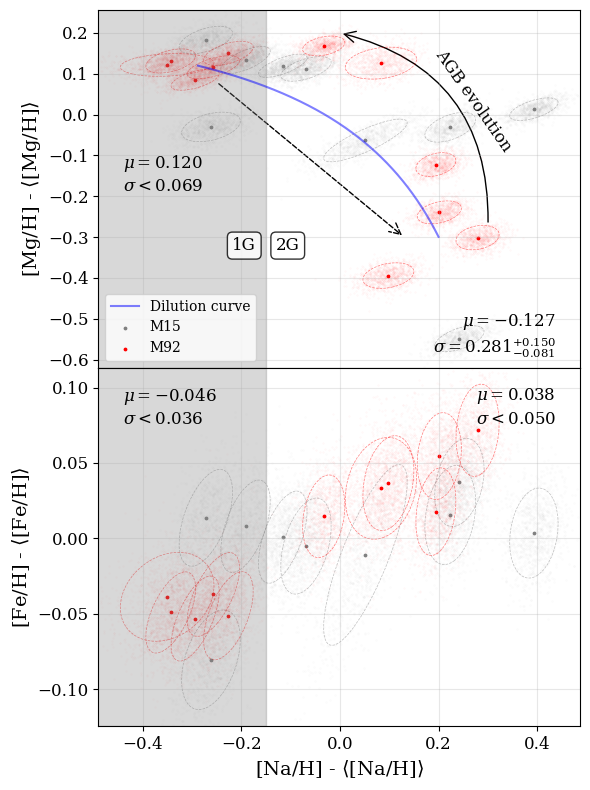

Plot saved to Na__Sr_Y_Zr.png


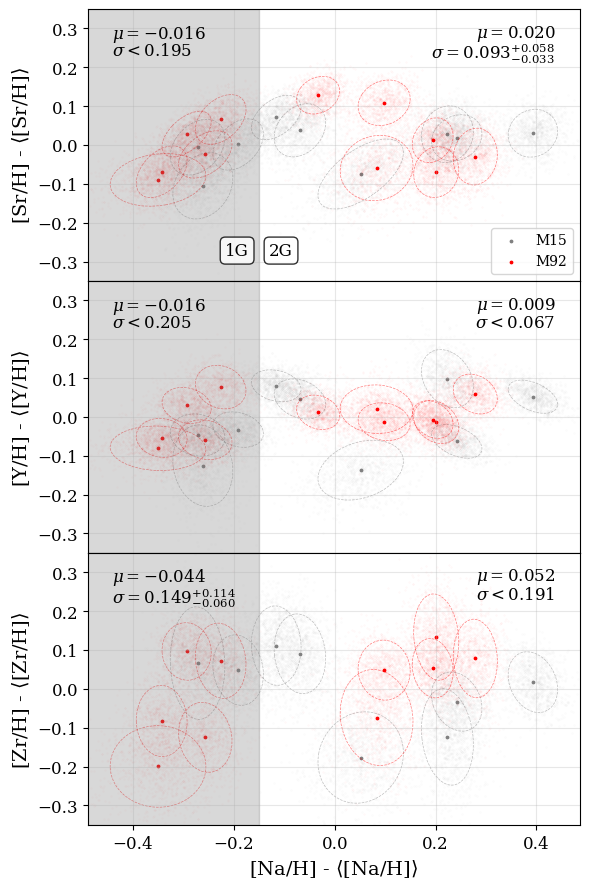

Plot saved to Na__Ba_La_Eu.png


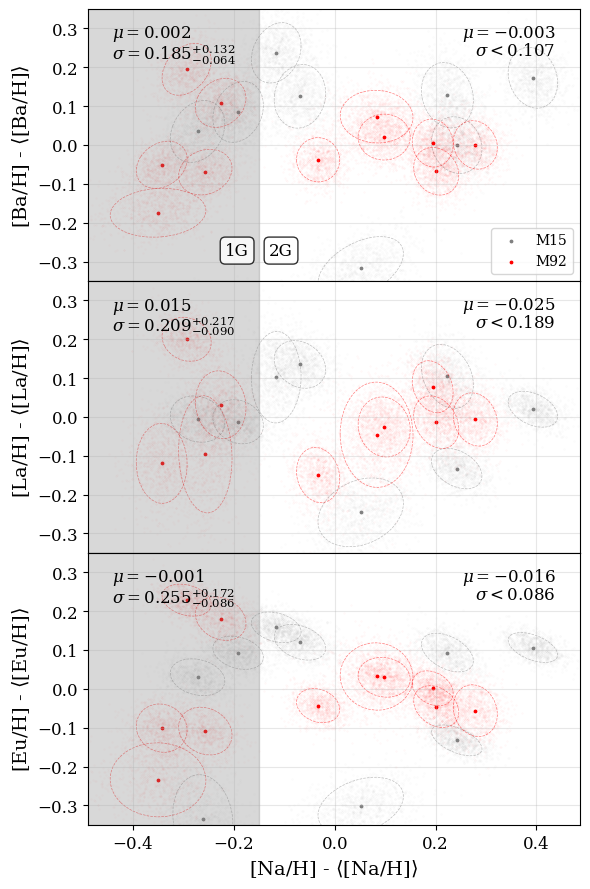

Plot saved to Na__Mg_Al_Si_K.png


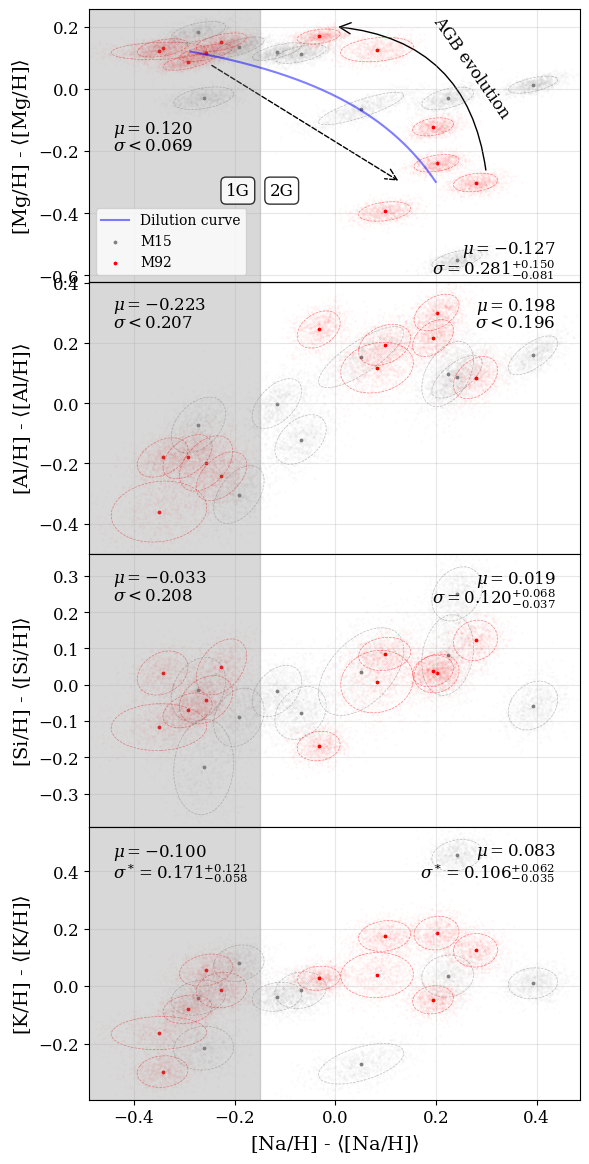

Plot saved to Mg__Na_Al_Si_K.png


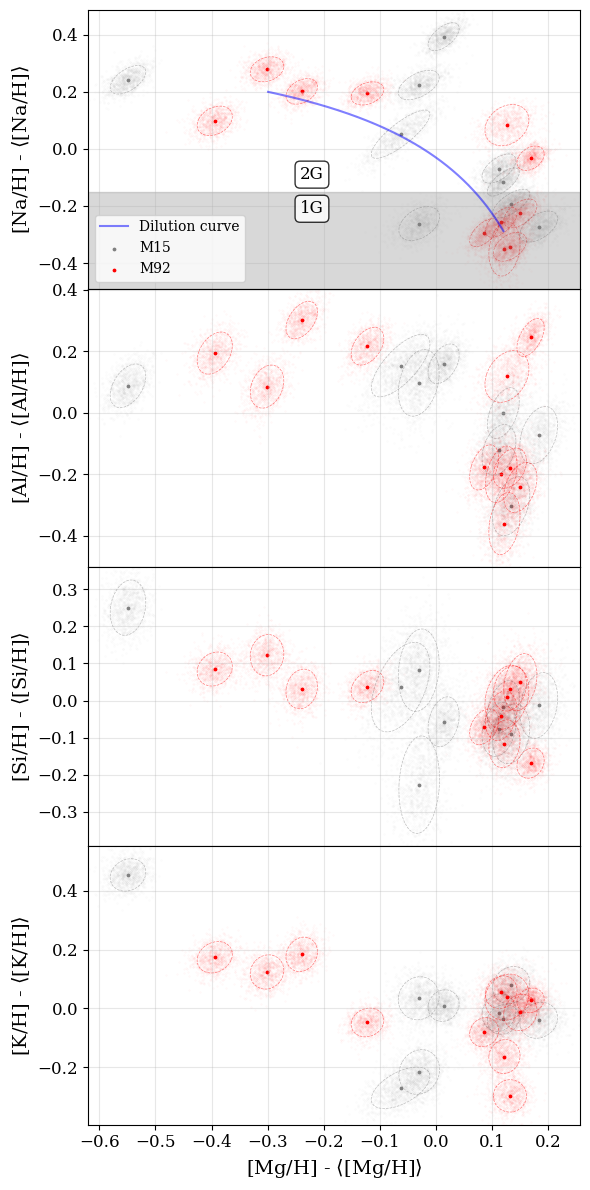

Plot saved to Na__Ca_Sc_Ti_V_Cr.png


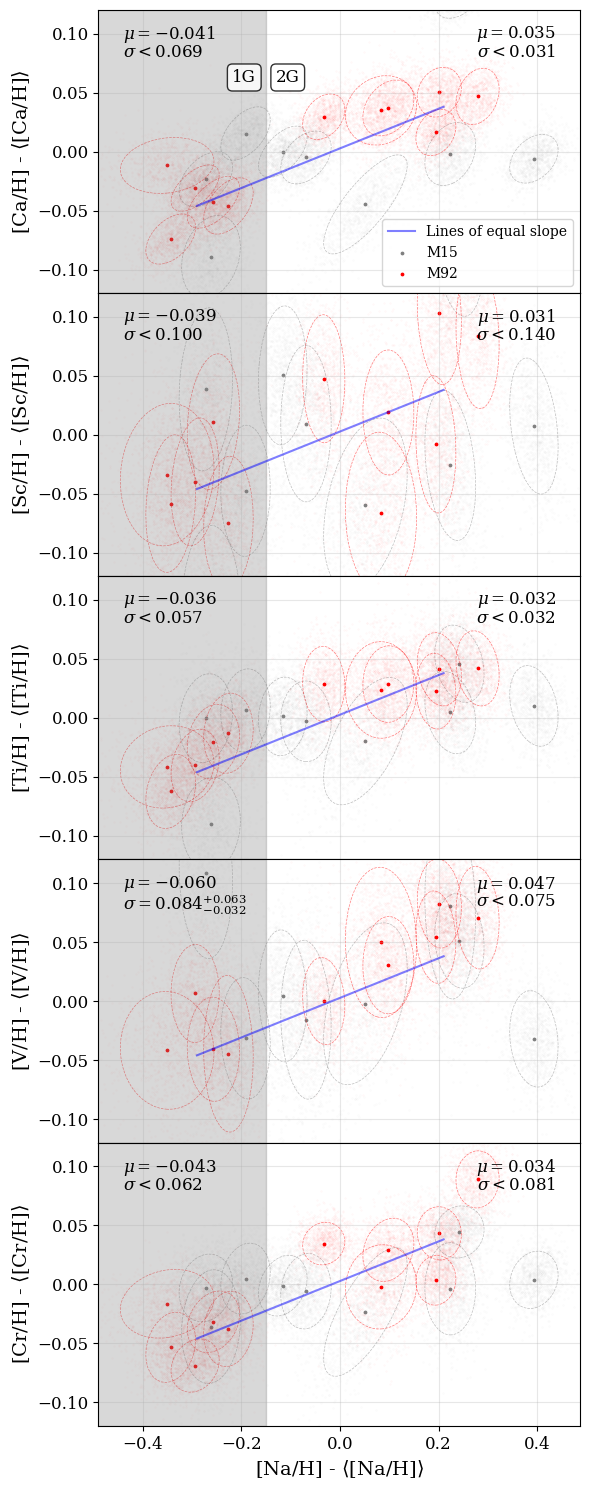

Plot saved to Na__Mn_Fe_Co_Ni_Zn.png


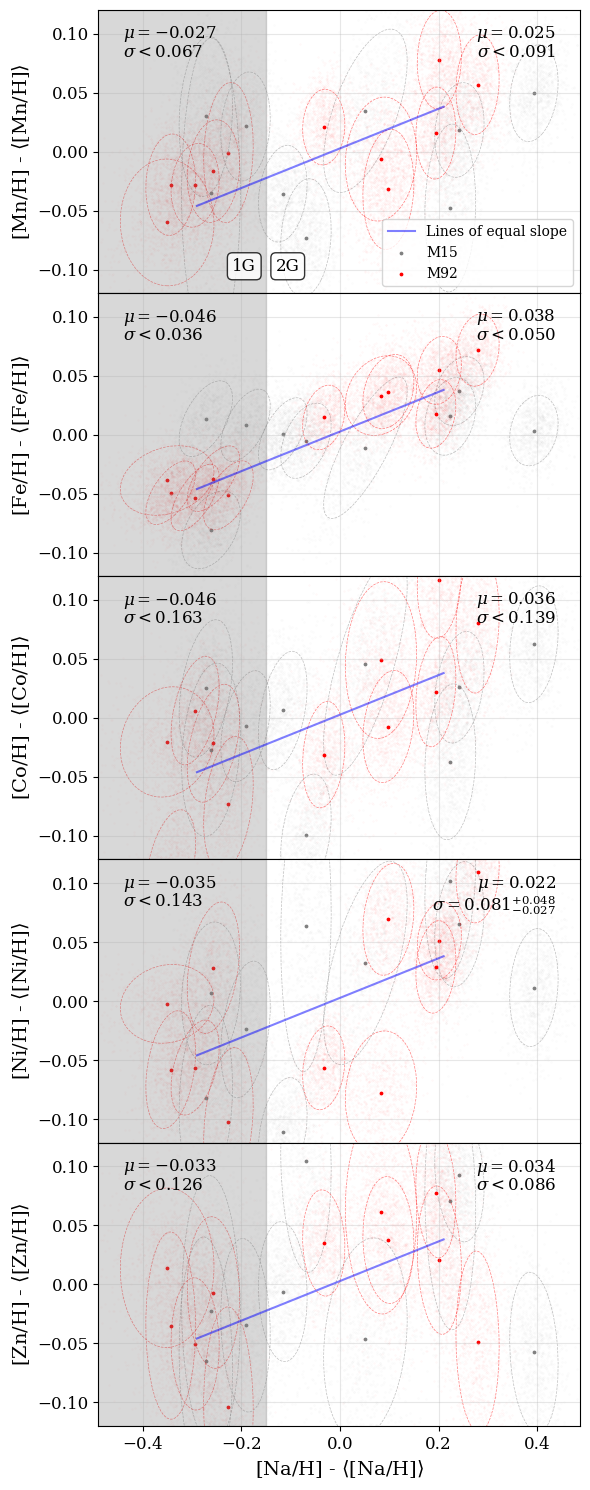

Plot saved to Na__Ba_Eu.png


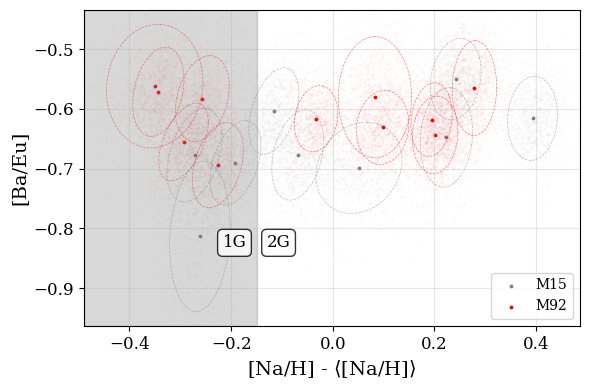

In [31]:
na_pop_split = -0.15
fe_pop_split = -0.015

# plot_abunddiff(avg_abunds, gcs=gcs, el1='Si', el2=['Al'])

#main text
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mg', 'Fe'], savefig='Na__Mg_Fe.png', gen_labels=True, shading=na_pop_split, showstats=True)
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Sr', 'Y', 'Zr'], savefig='Na__Sr_Y_Zr.png', shading=na_pop_split, ylim=[-0.35, 0.35], gen_labels=True, showstats=True)
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Ba', 'La', 'Eu'], savefig='Na__Ba_La_Eu.png', shading=na_pop_split, ylim=[-0.35, 0.35], gen_labels=True, showstats=True)

# # #supplementary
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mg', 'Al', 'Si', 'K'], savefig='Na__Mg_Al_Si_K.png', shading=na_pop_split, gen_labels=True, showstats=True)
plot_abunddiff(avg_abunds, gcs=gcs, el1='Mg', el2=['Na', 'Al', 'Si', 'K'], savefig='Mg__Na_Al_Si_K.png', gen_labels=True)
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Ca', 'Sc', 'Ti', 'V', 'Cr'], savefig='Na__Ca_Sc_Ti_V_Cr.png', shading=na_pop_split, ylim=[-0.12, 0.12], gen_labels=True, showstats=True)
plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mn', 'Fe', 'Co', 'Ni', 'Zn'], savefig='Na__Mn_Fe_Co_Ni_Zn.png', shading=na_pop_split, ylim=[-0.12, 0.12], gen_labels=True, showstats=True)
plot_abunddiff_ratio(avg_abunds, gcs=gcs, el1='Na', el2=[['Ba', 'Eu']], savefig='Na__Ba_Eu.png', shading=na_pop_split, gen_labels=True)

#plot_abunddiff(avg_abunds, gcs=gcs, el1='Na', el2=['Mg'], savefig='Na__Mg.png', shading=na_pop_split, gen_labels=True)
#plot_abunddiff(avg_abunds, gcs=gcs, el1='K', el2=['Ca'], shading=na_pop_split)
# plot_abunddiff(avg_abunds, gcs=gcs, el1='Si', el2=['Al', 'K', 'Ca'], savefig='Si__Al_K_Ca.png')
# plot_abunddiff(avg_abunds, gcs=gcs, el1='Fe', el2=['Al', 'Si', 'K', 'Ca', 'Co', 'Ni', 'Eu'], savefig='Fe__Si_Ca_Co_Ni_Eu.png', shading=fe_pop_split)
#plot_abunddiff(avg_abunds, gcs=gcs, el1='Fe', el2='Eu', shading=0.0)

In [32]:
import re

def natural_key(s):
    # Custom sort: M92 before M15, then natural sort for numbers
    s_lower = s.lower()
    if s_lower.startswith('m92'):
        prefix = 0
    elif s_lower.startswith('m15'):
        prefix = 1
    else:
        prefix = 2
    # Natural sort for the rest
    rest = [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]
    return [prefix] + rest

def make_latex_abundance_table(avg_abunds, star_names_full, precision=3, caption=None, label=None, filename='abundance_table.tex', elements_list=['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Nd', 'Eu', 'Dy']):
    """
    Output a LaTeX table of star names and their average abundances for all elements.
    avg_abunds: list of DataFrames (one per cluster)
    star_names_full: list of lists of star names (one per cluster)
    precision: number of decimal places
    caption: LaTeX caption string
    label: LaTeX label string
    """
    import numpy as np
    # Collect all unique star names and all unique elements
    all_star_names = []
    all_elements = set()
    star_to_abund = dict()
    star_to_abunderr = dict()
    for avg_abund, star_names in zip(avg_abunds, star_names_full):
        for idx, name in enumerate(star_names):
            all_star_names.append(name)
            for _, row in avg_abund.iterrows():
                element = row['element']
                all_elements.add(element)
                abunds = row['abunddiff']
                abunderrs = row['abunddifferr']
                if name not in star_to_abund:
                    star_to_abund[name] = dict()
                    star_to_abunderr[name] = dict()
                if idx < len(abunds):
                    star_to_abund[name][element] = abunds[idx]
                    star_to_abunderr[name][element] = abunderrs[idx]
                else:
                    star_to_abund[name][element] = np.nan
                    star_to_abunderr[name][element] = np.nan
    # Remove duplicates in star names, keep order
    seen = set()
    unique_star_names = []
    for name in all_star_names:
        if name not in seen:
            unique_star_names.append(name)
            seen.add(name)
    # Build LaTeX table
    unique_star_names = sorted(unique_star_names, key=natural_key)
    header = r"\begin{sidewaystable}\n"
    if caption:
        header += f"\\caption{{{caption}}}"
    if label:
        header += f"\\label{{{label}}}"
    header += "\n"
    header += r"\begin{tabular*}{\textheight}{@{\extracolsep\fill}l " + " ".join(["c"]*len(elements_list)) + r"@{}}\n"
    header += r"\toprule\n"
    header += "Star"
    for el in elements_list:
        header += f" & {el}"
    header += r" \\ \midrule\n"
    body = ""
    for name in unique_star_names:
        body += name
        for el in elements_list:
            abund = star_to_abund.get(name, {}).get(el, np.nan)
            abunderr = star_to_abunderr.get(name, {}).get(el, np.nan)
            abund_str = f"${abund:+.{precision}f} \\pm {abunderr:.{precision}f}$" if np.isfinite(abund) else "---"
            body += f" & {abund_str}"
        body += r" \\ \n"
    footer = r"\botrule\n\end{tabular*}\n"
    footer += r"\end{sidewaystable}"
    latex_table = header + body + footer
    with open(filename, 'w') as f:
        f.write(latex_table.replace("\\n", "\n"))
    return latex_table.replace("\\n", "\n")


def make_latex_average_abund_table():
    cat = get_catalog()
    avg_abunds = []
    star_names_full = []
    for cluster in cat:
        avg_abunds.append(cluster['avg_abund'])
        star_names_full.append(cluster['star_names'])
        
        
make_latex_abundance_table(avg_abunds, star_names_full, caption='Differential abundances for all stars.', label='tab:allabund')
make_latex_abundance_table(avg_abunds, star_names_full, filename='abundance_table1.tex', caption='Differential abundances for Na through Ti.', label='tab:abund1', elements_list=['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti'])
make_latex_abundance_table(avg_abunds, star_names_full, filename='abundance_table2.tex', caption='Differential abundances for V through Sr.', label='tab:abund2', elements_list=['V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Zn', 'Sr'])
make_latex_abundance_table(avg_abunds, star_names_full, filename='abundance_table3.tex', caption='Differential abundances for Y through Dy.', label='tab:abund3', elements_list=['Y', 'Zr', 'Ba', 'La', 'Nd', 'Eu', 'Dy'])



'\\begin{sidewaystable}\n\\caption{Differential abundances for Y through Dy.}\\label{tab:abund3}\n\\begin{tabular*}{\\textheight}{@{\\extracolsep\\fill}l c c c c c c c@{}}\n\\toprule\nStar & Y & Zr & Ba & La & Nd & Eu & Dy \\\\ \\midrule\nM92-star-1 & $-0.081 \\pm 0.038$ & $-0.200 \\pm 0.069$ & $-0.174 \\pm 0.041$ & --- & --- & $-0.234 \\pm 0.063$ & --- \\\\ \nM92-star-2 & $+0.059 \\pm 0.034$ & $+0.078 \\pm 0.067$ & $+0.000 \\pm 0.041$ & $-0.007 \\pm 0.045$ & --- & $-0.056 \\pm 0.044$ & $+0.061 \\pm 0.161$ \\\\ \nM92-star-3 & $-0.013 \\pm 0.037$ & $+0.133 \\pm 0.073$ & $-0.068 \\pm 0.040$ & $-0.014 \\pm 0.045$ & $-0.255 \\pm 0.073$ & $-0.046 \\pm 0.036$ & --- \\\\ \nM92-star-4 & $-0.007 \\pm 0.032$ & $+0.053 \\pm 0.050$ & $+0.005 \\pm 0.041$ & $+0.078 \\pm 0.044$ & $+0.028 \\pm 0.074$ & $+0.001 \\pm 0.030$ & --- \\\\ \nM92-star-6 & $+0.030 \\pm 0.031$ & $+0.096 \\pm 0.049$ & $+0.195 \\pm 0.044$ & $+0.200 \\pm 0.037$ & $+0.132 \\pm 0.058$ & $+0.228 \\pm 0.027$ & $+0.100 \\pm 0.075$ \\\\

In [33]:
def make_cluster_avgabund_latex_table(avg_abunds, gcs=['M15', 'M92'], precision=3, caption=None, label=None, filename='avgabund_table.tex'):
    """
    Output a LaTeX table with columns: element, M92 avgabund, M15 avgabund.
    avg_abunds: list of DataFrames, one per cluster, in the same order as gcs
    gcs: list of cluster names, order must match avg_abunds
    """
    import numpy as np
    # Collect all unique elements
    all_elements = set()
    for avg_abund in avg_abunds:
        all_elements.update(avg_abund['element'].tolist())
    elements_list = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Zn', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Nd', 'Eu', 'Dy']
    # Build lookup for each cluster
    cluster_lookup = []
    for avg_abund in avg_abunds:
        lookup = {row['element']: row['avgabund'] for _, row in avg_abund.iterrows()}
        cluster_lookup.append(lookup)
    # Build LaTeX table
    header = r"\begin{table}[h!]\n"
    if caption:
        header += f"\\caption{{{caption}}}\label{{tab:avgabund}}"
    if label:
        header += f"\\label{{{label}}}"
    header += "\n"
    header += r"\begin{tabular}{lcc}\n"
    header += r"\toprule\n"
    header += "Element & " + " & ".join(gcs) + r" \\ \midrule\n"
    body = ""
    for el in elements_list:
        row = [el]
        for i in range(len(gcs)):
            val = cluster_lookup[i].get(el, np.nan)
            val_str = f"${val:+.{precision}f}$" if np.isfinite(val) else "---"
            row.append(val_str)
        body += " & ".join(row) + r" \\ \n"
    footer = r"\bottomrule\n\end{tabular}\n"
    footer += r"\end{table}"
    latex_table = header + body + footer
    with open(filename, 'w') as f:
        f.write(latex_table.replace("\\n", "\n"))
    return latex_table.replace("\\n", "\n")

make_cluster_avgabund_latex_table(avg_abunds, caption='Average abundances ($12 + \log n({\mathrm X})/n({\mathrm H}))$) in each cluster.')


<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_638085/3242068711.py:21: SyntaxWarning: invalid escape sequence '\l'
  header += f"\\caption{{{caption}}}\label{{tab:avgabund}}"
/tmp/ipykernel_638085/3242068711.py:43: SyntaxWarning: invalid escape sequence '\l'
  make_cluster_avgabund_latex_table(avg_abunds, caption='Average abundances ($12 + \log n({\mathrm X})/n({\mathrm H}))$) in each cluster.')


'\\begin{table}[h!]\n\\caption{Average abundances ($12 + \\log n({\\mathrm X})/n({\\mathrm H}))$) in each cluster.}\\label{tab:avgabund}\n\\begin{tabular}{lcc}\n\\toprule\nElement & M15 & M92 \\\\ \\midrule\nNa & $+4.472$ & $+4.242$ \\\\ \nMg & $+5.396$ & $+5.385$ \\\\ \nAl & $+4.016$ & $+3.980$ \\\\ \nSi & $+5.478$ & $+5.587$ \\\\ \nK & $+3.248$ & $+3.218$ \\\\ \nCa & $+4.208$ & $+4.233$ \\\\ \nSc & $+0.838$ & $+0.807$ \\\\ \nTi & $+2.833$ & $+2.839$ \\\\ \nV & $+1.618$ & $+1.682$ \\\\ \nCr & $+3.012$ & $+3.059$ \\\\ \nMn & $+2.483$ & $+2.538$ \\\\ \nFe & $+5.019$ & $+5.056$ \\\\ \nCo & $+2.698$ & $+2.729$ \\\\ \nNi & $+3.699$ & $+3.753$ \\\\ \nZn & $+2.278$ & $+2.271$ \\\\ \nSr & $+0.300$ & $+0.242$ \\\\ \nY & $-0.247$ & $-0.389$ \\\\ \nZr & $+0.433$ & $+0.370$ \\\\ \nBa & $-0.142$ & $-0.502$ \\\\ \nLa & $-0.778$ & $-1.136$ \\\\ \nNd & $-0.321$ & $-0.634$ \\\\ \nEu & $-1.120$ & $-1.540$ \\\\ \nDy & $-0.419$ & $-0.768$ \\\\ \n\\bottomrule\n\\end{tabular}\n\\end{table}'

In [34]:
from astropy.coordinates import Angle

def make_star_table(caption=None, label=None, filename='starlist_table.tex'):
    gaia = pd.concat([get_gaia('M92'), get_gaia(gc='M15')])
    gaia_coords = SkyCoord([sc for sc in gaia['skycoord']])
        
    cat = get_catalog()
    starstr = []
    for name in cat['NAME']:
        starstr.append(name.decode('utf-8'))
    starstr = [s for s in starstr if ((s.strip() != 'M92-star-5') & (s.strip() != 'M92-star-7'))]
    # Remove duplicates in star names, keep order
    seen = set()
    unique_star_names = []
    for name in starstr:
        if name not in seen:
            unique_star_names.append(name)
            seen.add(name)
    # Build LaTeX table
    unique_star_names = sorted(unique_star_names, key=natural_key)

    nm92 = len([name for name in unique_star_names if name.startswith('M92')])
    nm15 = len([name for name in unique_star_names if name.startswith('M15')])
    flatex.write(r"\newcommand{\nmone}{"+str(nm92)+"}\n")
    flatex.write(r"\newcommand{\nmtwo}{"+str(nm15)+"}\n")
    flatex.write(r"\newcommand{\nmtotal}{"+str(nm92+nm15)+"}\n")
    
    m92_mask = cat['NAME'].apply(lambda x: x.decode('utf-8').strip().startswith('M92'))
    m92_cat = cat[m92_mask]
    print(m92_mask)
    print(m92_cat['NAME'])
    print(m92_cat['teff'])
    print(m92_cat['teff'].max(), m92_cat['teff'].min())
    flatex.write(r"\newcommand{\teffrangeone}{"+str(int(m92_cat['teff'].max()-m92_cat['teff'].min()))+"}\n")
    flatex.write(r"\newcommand{\loggrangeone}{"+f"{m92_cat['logg'].max()-m92_cat['logg'].min():.2f}"+"}\n")
    flatex.write(r"\newcommand{\vtrangeone}{"+f"{m92_cat['vt'].max()-m92_cat['vt'].min():.2f}"+"}\n")

    m15_mask = cat['NAME'].apply(lambda x: x.decode('utf-8').strip().startswith('M15'))
    m15_cat = cat[m15_mask]
    flatex.write(r"\newcommand{\teffrangetwo}{"+str(int(m15_cat['teff'].max()-m15_cat['teff'].min()))+"}\n")
    flatex.write(r"\newcommand{\loggrangetwo}{"+f"{m15_cat['logg'].max()-m15_cat['logg'].min():.2f}"+"}\n")
    flatex.write(r"\newcommand{\vtrangetwo}{"+f"{m15_cat['vt'].max()-m15_cat['vt'].min():.2f}"+"}\n")

    flatex.write(r"\newcommand{\teffrangemax}{"+str(int(np.maximum(m92_cat['teff'].max()-m92_cat['teff'].min(), m15_cat['teff'].max()-m15_cat['teff'].min())))+"}\n")
    flatex.write(r"\newcommand{\loggrangemax}{"+f"{np.maximum(m92_cat['logg'].max()-m92_cat['logg'].min(), m15_cat['logg'].max()-m15_cat['logg'].min()):.2f}"+"}\n")
    flatex.write(r"\newcommand{\vtrangemax}{"+f"{np.maximum(m92_cat['vt'].max()-m92_cat['vt'].min(), m15_cat['vt'].max()-m15_cat['vt'].min()):.2f}"+"}\n")

    header = r"\begin{sidewaystable}\n"
    if caption:
        header += f"\\caption{{{caption}}}"
    if label:
        header += f"\\label{{{label}}}"
    header += "\n"
    header += r"\begin{tabular}{llccccccc}\n"
    header += r"\toprule\n"
    header += r"{\it Gaia} DR3 ID & Nickname & RA & Dec & $G$ & $BP - RP$ & $T_{\rm eff}$ (K)\footnotemark[1] & $\log g$ (cm s$^{-2}$) & $\xi$ (km s$^{-1}$) \\ \midrule\n"
    body = ""
    for star in unique_star_names:
        cat_row = cat[cat['NAME'] == star.encode('utf-8')]
        idx, d2d, d3d = SkyCoord(cat_row.iloc[0]['skycoord']).match_to_catalog_sky(gaia_coords)
        rastr = Angle(cat_row['RA'].values[0] * u.deg).to_string(unit='hourangle', sep='hms', precision=2, pad=True)
        decstr = Angle(cat_row['DEC'].values[0] * u.deg).to_string(unit='deg', sep='dms', precision=2, pad=True, alwayssign=True)
        gaiaidstr = f"{gaia.iloc[idx]['source_id']}"
        gstr = f"{gaia.iloc[idx]['phot_g_mean_mag']:.4f}"
        bprpstr = f"{(gaia.iloc[idx]['phot_bp_mean_mag'] - gaia.iloc[idx]['phot_rp_mean_mag']):.4f}"
        teffstr = f"{cat_row['teff'].values[0]:0.0f}"
        tefferrstr = f"{np.sqrt(cat_row['tefferr'].values[0]**2 - 83**2):0.0f}"
        loggstr = f"{cat_row['logg'].values[0]:.2f}"
        loggerrstr = f"{cat_row['loggerr'].values[0]:.2f}"
        vtstr = f"{cat_row['vt'].values[0]:.2f}"
        vterrstr = f"{cat_row['vterr'].values[0]:.2f}"
        val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & ${loggstr} \pm {loggerrstr}$ & ${vtstr} \pm {vterrstr}$"
        body += val_str + r" \\ \n"
    footer = r"\bottomrule\n\end{tabular}\n"
    footer += r"\footnotetext[1]{The uncertainty is the random component propagated from the $B_P-R_P$ color.  The color--$T_{\rm eff}$ relation\citep{muc21} gives an additional systematic uncertainty of 83~K\@.  The Methods section discusses our separate treatment of these errors.}"
    footer += r"\end{sidewaystable}"
    latex_table = header + body + footer
    with open(filename, 'w') as f:
        f.write(latex_table.replace("\\n", "\n"))
    return

make_star_table(caption='Star coordinates and atmospheric parameters.', label='tab:starcoords', filename='starlist_table.tex')

<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
<>:72: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_638085/983204901.py:72: SyntaxWarning: invalid escape sequence '\p'
  val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & ${loggstr} \pm {loggerrstr}$ & ${vtstr} \pm {vterrstr}$"
/tmp/ipykernel_638085/983204901.py:72: SyntaxWarning: invalid escape sequence '\p'
  val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & ${loggstr} \pm {loggerrstr}$ & ${vtstr} \pm {vterrstr}$"
/tmp/ipykernel_638085/983204901.py:72: SyntaxWarning: invalid escape sequence '\p'
  val_str = f"{gaiaidstr} & {star} & {rastr} & {decstr} & {gstr} & {bprpstr} & ${teffstr} \pm {tefferrstr}$ & $

0      True
1     False
2     False
3     False
4      True
5      True
6      True
7     False
8      True
9      True
10    False
11    False
12     True
13     True
14     True
15    False
16    False
17     True
18     True
19     True
20    False
Name: NAME, dtype: bool
0     b'M92-star-12'
4     b'M92-star-6 '
5     b'M92-star-4 '
6     b'M92-star-11'
8     b'M92-star-5 '
9     b'M92-star-1 '
12    b'M92-star-9 '
13    b'M92-star-13'
14    b'M92-star-8 '
17    b'M92-star-10'
18    b'M92-star-2 '
19    b'M92-star-3 '
Name: NAME, dtype: object
0     5026.985394
4     5014.983542
5     5013.551421
6     5024.478534
8             NaN
9     5001.093113
12    5011.564117
13    5017.234345
14    4984.551514
17    5016.099838
18    5006.068973
19    5012.225689
Name: teff, dtype: float64
5026.985394013106 4984.551513825633


In [35]:

def make_cmd():
    gcs = ['M92', 'M15']
    cat = get_catalog()
    starstr = []
    for name in cat['NAME']:
        starstr.append(name.decode('utf-8').strip())
    cat_coords = SkyCoord([sc for (sc, name) in zip(cat['skycoord'], starstr) if ((name != 'M92-star-5') & (name != 'M92-star-7'))])
    starstr = [s for s in starstr if ((s != 'M92-star-5') & (s != 'M92-star-7'))]
    fig = plt.figure(figsize=(8, 6))
    axs = [fig.add_subplot(121), fig.add_subplot(122)]
    for i, gc in enumerate(gcs):
        catgc = [s.startswith(gc) for s in starstr]
        gaia = get_gaia(gc=gc)
        
        gaia_coords = SkyCoord([sc for sc in gaia['skycoord']])
        meanra = np.mean(gaia['ra'])
        meandec = np.mean(gaia['dec'])
        mean_coords = SkyCoord(ra=meanra, dec=meandec, unit='deg')
        sep = gaia_coords.separation(mean_coords)
        pm = np.sqrt(gaia['pmra']**2 + gaia['pmdec']**2)
        meanpm = np.nanmean(pm)
        mask = (sep > 3*u.arcmin) & (abs(pm-meanpm) < 2.0)
        idx, d2d, d3d = cat_coords[catgc].match_to_catalog_sky(gaia_coords)
        
        # Main CMD panel
        axs[i].scatter(gaia[mask]['phot_bp_mean_mag']-gaia[mask]['phot_rp_mean_mag'], gaia[mask]['phot_g_mean_mag'], s=0.3, alpha=0.2, color='k')
        axs[i].set_xlabel(r'$BP - RP$')
        axs[i].set_ylabel(r'$G$')
        axs[i].set_title(f'{gc}')
        axs[i].scatter(gaia.iloc[idx]['phot_bp_mean_mag']-gaia.iloc[idx]['phot_rp_mean_mag'], gaia.iloc[idx]['phot_g_mean_mag'], s=1,color='red')
        axs[i].set_xlim(-0.3, 1.75)
        axs[i].set_ylim(19, 11)
        
        # Add inset axes for zoom-in region
        axins = inset_axes(axs[i], width="40%", height="30%", loc='upper left', borderpad=1)
        # Define zoom region (customize as needed)
        if gc == 'M92':
            x1, x2 = 1.01, 1.11  # BP-RP range for zoom
            y1, y2 = 14.52, 14.32    # G mag range for zoom (brighter is lower)
        elif gc == 'M15':
            x1, x2 = 1.11, 1.21  # BP-RP range for zoom
            y1, y2 = 15.24, 15.04    # G mag range for zoom (brighter is lower)
        else:
            raise NotImplementedError("Zoom region not defined for this cluster.")
            
        axins.scatter(gaia[mask]['phot_bp_mean_mag']-gaia[mask]['phot_rp_mean_mag'], gaia[mask]['phot_g_mean_mag'], s=0.8, alpha=0.7, color='k')
        axins.scatter(gaia.iloc[idx]['phot_bp_mean_mag']-gaia.iloc[idx]['phot_rp_mean_mag'], gaia.iloc[idx]['phot_g_mean_mag'], s=1.5,color='red')
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        #axins.set_xticks([])
        #axins.set_yticks([])
        axins.yaxis.tick_right()
        axins.yaxis.set_label_position('right')
        # Draw a box on the main panel to show the zoomed region
        mark_inset(axs[i], axins, loc1=3, loc2=4, fc="none", ec="0.75")
    plt.tight_layout()
    plt.savefig("m92_m15_cmd.png", dpi=300)

make_cmd()

/tmp/ipykernel_638085/1006612684.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_638085/1006612684.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [36]:
c = 2.99792458e5

def vacuum_to_air(wl_vac):
    """Convert vacuum wavelengths (in Angstroms) to air wavelengths (in Angstroms) using the standard formula."""
    # Ciddor 1996 formula (recommended for high-precision work)
    s = 1e4 / wl_vac  # inverse microns
    n = 1 + 0.0000834254 + 0.02406147 / (130.106592 - s**2) + 0.00015998 / (38.92568793 - s**2)
    wl_air = wl_vac * n
    return wl_air

def read_spectrum(star, vr=0):
    fname = 'spectra/'+star+'.fits.gz'
    with fits.open(fname) as hdul:
        data = hdul[1].data
        #header = hdul[1].header
        wl_vac = data['lambda'] / (1 + vr / c)
        wl_air = vacuum_to_air(wl_vac)
        flux = data['spec']
        ivar = data['ivar']
    return {'wl':wl_air, 'flux':flux, 'ivar':ivar}

def make_spectra_figure():
    import matplotlib.gridspec as gridspec
    from matplotlib.ticker import ScalarFormatter
    gcs = ['M92']
    cat = get_catalog()
    starstr = []
    for name in cat['NAME']:
        starstr.append(name.decode('utf-8'))
    
    #waves = [(4129.208, 4130.208), (4570.596, 4571.596), (4583.329, 4584.329), (5895.424, 5896.424)]
    #labels = ['Eu II 4129.708', 'Mg I 4571.096', 'Fe II 4583.829', 'Na I 5895.924']
    waves = [(4522.073, 4523.128), (4570.596, 4571.596), (4583.329, 4584.329), (4602.441, 4603.441), (5895.424, 5896.424)]
    labels = ['Eu II, Fe II 4523', 'Mg I 4571', 'Fe II 4584', 'Fe I 4603', 'Na I 5896']
    nwaves = len(waves)
    # Calculate width ratios based on xlim range
    width_ratios = [w[1] - w[0] for w in waves]

    for gc in gcs:
        stargc = [s for s in starstr if s.startswith(gc)]
        
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(1, nwaves, width_ratios=width_ratios, wspace=0)
        axs = [fig.add_subplot(gs[0, j]) for j in range(nwaves)]
        for j in range(nwaves):
            axs[j].set_xlim(waves[j])
            axs[j].set_ylim(0.15, 1.06)
            if j != 0:
                axs[j].set_yticklabels([])
                axs[j].set_ylabel("")
            else:
                axs[j].set_ylabel("normalized flux")
            # Show full value of each tick in the x-axis
            axs[j].xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
            axs[j].ticklabel_format(style='plain', axis='x')
        for i, star in enumerate(stargc):
            if (star.strip() == 'M92-star-5') | (star.strip() == 'M92-star-7'):
                continue
            cat_row = cat[cat['NAME'] == star.encode('utf-8')]
            spec = read_spectrum(star.strip(), vr = cat_row['VR'].values[0])
            for j in range(nwaves):
                w = (spec['wl'] > waves[j][0]) & (spec['wl'] < waves[j][1])
                axs[j].plot(spec['wl'][w], spec['flux'][w], label=star, linewidth=0.7)
                if i==0:
                    axs[j].text(0.06, 0.025, labels[j], transform=axs[j].transAxes, fontsize=12, fontweight='normal')
        fig.text(0.5, 0.01, 'rest wavelength (Å)', ha='center', va='center', fontsize=14, wrap=True)
        fig.subplots_adjust(bottom=0.13)  # Increase space above x-axis label
        # Prevent x-axis label overlap
        for ax in axs:
            for label in ax.get_xticklabels():
                label.set_rotation(30)
                label.set_horizontalalignment('right')
        # Hide the leftmost tick of the second subplot
        # if len(axs) > 1:
        #     xticklabels = axs[1].get_xticklabels()
        #     if len(xticklabels) > 0:
        #         xticklabels[1].set_visible(False)
        plt.savefig(gc+'_spectra.png', bbox_inches='tight')

make_spectra_figure()

In [37]:
flatex.close()

In [38]:
with open('/raid/caltech/hires/M15_M92/avg_abund.pkl', 'rb') as f:
    cat = pickle.load(f)
    avg_abunds = pickle.load(f)
    star_names = pickle.load(f)
gcs = ['M15', 'M92']
for i,gc in enumerate(gcs):
    a = avg_abunds[i]
    for j,el in enumerate(a['element']):
        mask = np.isfinite(a['abunddiff'][j]) & np.isfinite(a['abunddifferr'][j]) & (np.array(a['abunddifferr'][j]) > 0)
        abunddiff = np.array(a['abunddiff'][j])[mask]
        if len(abunddiff) == 0:
            continue
        abunddifferr = (np.array(a['abunddifferr'][j])[mask])**(-2)
        meanabund = np.average(abunddiff, weights=abunddifferr)
        print(f"Globular Cluster: {gc}, Star: Element: {el}, Mean abundance difference: {meanabund}")

Globular Cluster: M15, Star: Element: Al, Mean abundance difference: 0.017346449250381292
Globular Cluster: M15, Star: Element: Ba, Mean abundance difference: -0.011468060567046318
Globular Cluster: M15, Star: Element: Ca, Mean abundance difference: 0.00980172799274768
Globular Cluster: M15, Star: Element: Ce, Mean abundance difference: 0.00012037400891074979
Globular Cluster: M15, Star: Element: Co, Mean abundance difference: -0.0005098758226931733
Globular Cluster: M15, Star: Element: Cr, Mean abundance difference: 0.0065177251048253535
Globular Cluster: M15, Star: Element: Dy, Mean abundance difference: 0.007155017921593116
Globular Cluster: M15, Star: Element: Eu, Mean abundance difference: 0.04075541462505997
Globular Cluster: M15, Star: Element: Fe, Mean abundance difference: 0.0002646785390649991
Globular Cluster: M15, Star: Element: K, Mean abundance difference: 0.024353568065023007
Globular Cluster: M15, Star: Element: La, Mean abundance difference: -0.008777425040924816
Globu

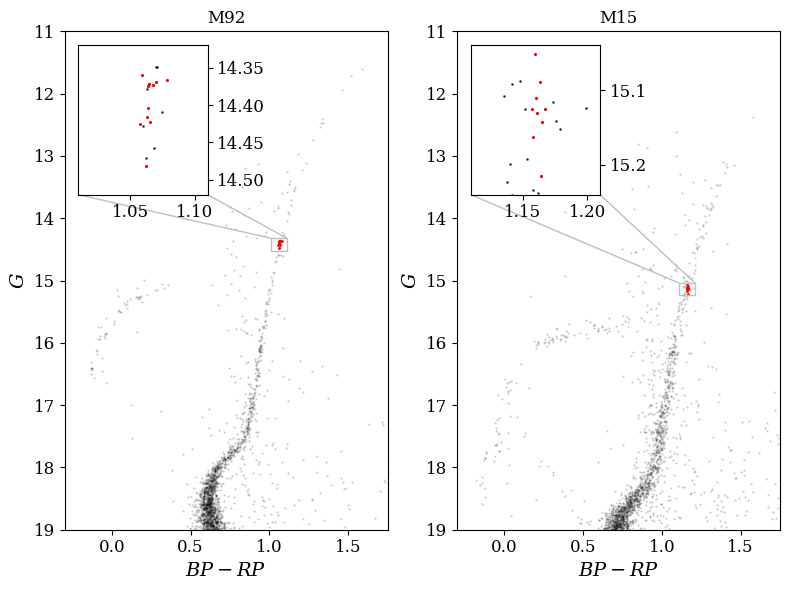

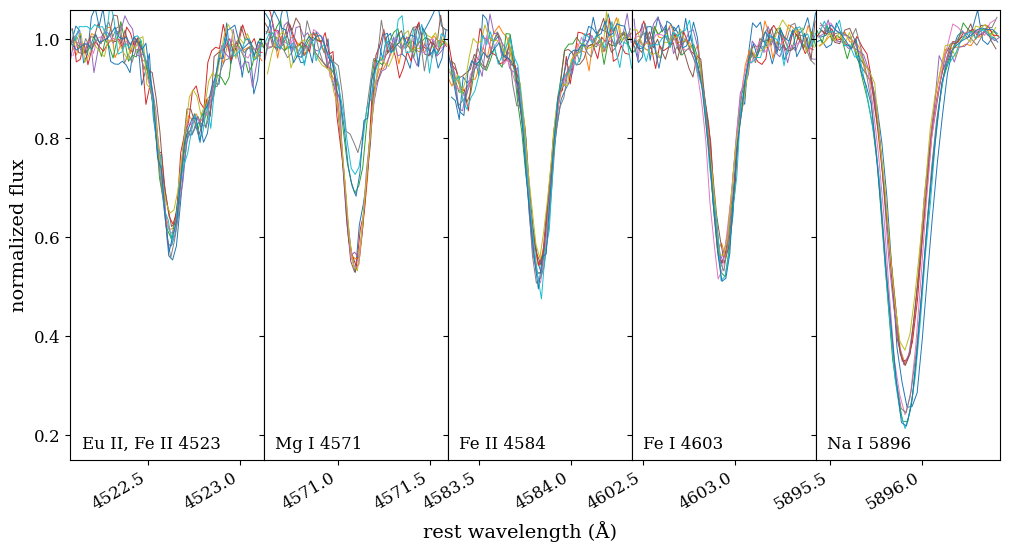

In [39]:
plt.show()